# Analysis for GPT paper [revision]



## 0. Preamble

In [309]:
from __future__ import unicode_literals

%matplotlib inline

#Some imports
import matplotlib.patches as mpatches

import random

#Imports
#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim')

#Proc data (to place seed etc)
proc_data = os.path.join(top,'data/processed')

#Figures
fig_path = os.path.join(top,'reports/figures')

#Models
mod_path = os.path.join(top,'models')


#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])


In [13]:
# Basic functions

#Flatten list

def flatten_list(a_list):
    '''
    Utility function that takes a list of nested elements and flattens it
    
    '''
    
    return([x for el in a_list for x in el])

def flatten_freqs(a_list):
    '''
    Utility function that flattens a list and returns element frequencies
    
    '''
    
    #This flattens the list and returns value counts
    return(pd.Series(flatten_list(a_list)).value_counts())


#Functions
def create_lq_df(df,year=None):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    
    if year!=None:
        lqs['period'] = year
    
    return(lqs)


## 1. Load data

We have two datasets:

1. One includes all CS papers obtained from ArXiv.
2. One includes all CS papers with a DOI (need to check what's the exact difference in status between both categories). 

For now we will focus on number one. We are thinking of number 2 as more of a robustness checks variable.

In [14]:
# Load the papers

papers = pd.read_json(
    ext_data+'/corex_matched_noOAG.json',orient='records')

papers.shape

(247931, 60)

There are 247,931 papers. This is total number of CS + Stats papers in Arxiv CS papers (see methodology in paper for a description of the process used for this)

## 2. Initial exploration

In [15]:
#Note that there are many duplicated papers. This seems to be linked to the way they have been geocoded
len(set(papers.arxiv_id))

131189

In [16]:
#The only difference between papers I can find is in the latitude and longitude. 
#TODO: Check with Joel what's going on here.

#for column in papers.columns:
#    print(column)
#    print(papers.loc[0,column])
#    print(papers.loc[1,column])
#    
#    print('\n')   

In [17]:
#Check the data
papers.head()

,TOPIC_algorithm_problem_optimization_optimization problem_solve_solution_solving_approximation_efficient_convergence,TOPIC_approach_based_technique_existing_framework_based approach_approach based_new approach_using_novel approach,TOPIC_architecture_memory_parallel_network architecture_hardware_processor_cpu_computing_gpu_core,TOPIC_bound_upper_upper bound_np_polynomial time_constant_np hard_case_time algorithm_known,TOPIC_channel_interference_transmission_wireless_receiver_rate_antenna_transmitter_mimo_transmit,TOPIC_data_data set_data structure_real data_data analysis_big data_data driven_data point_collected_synthetic data,TOPIC_different_two different_different type_three different_different approach_across different_many different_different level_using different_different way,TOPIC_dimensional_sparse_high dimensional_space_sparsity_low rank_vector_dimension_recovery_sample,TOPIC_et_al_et al_polynomial_give_whether_proof_complete_every_theorem,TOPIC_experiment_experiment show_extensive experiment_high quality_high_result indicate_quality_indicate_extensive_resolution,...,full_title,grid_lat,grid_lon,institutes,journal,language,match_score,match_value,matched,title
0,0.428542,0.042882,0.0,0.000000,0.000000,0.000000,0.000000,0.074204,0.052545,0.0,...,Sparsity-certifying Graph Decompositions,[42.318119],[-72.638139],"[smith college, university of massachusetts am...",Graphs and Combinatorics,en,1.0,Smith College,True,sparsity certifying graph decompositions
1,0.428542,0.042882,0.0,0.000000,0.000000,0.000000,0.000000,0.074204,0.052545,0.0,...,Sparsity-certifying Graph Decompositions,[42.389002],[-72.526712],"[smith college, university of massachusetts am...",Graphs and Combinatorics,en,1.0,University of Massachusetts Amherst,True,sparsity certifying graph decompositions
2,0.157418,0.042882,0.0,0.000000,0.054565,0.526032,0.524284,0.020608,0.000000,0.0,...,Intelligent location of simultaneously active ...,[46.049268],[14.505099],[university of ljubljana],Aircraft Engineering and Aerospace Technology,en,1.0,University of Ljubljana,True,intelligent location of simultaneously active ...
3,0.206328,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,Intelligent location of simultaneously active ...,[46.049268],[14.505099],[university of ljubljana],arXiv preprint arXiv:0704.0050,en,1.0,University of Ljubljana,True,intelligent location of simultaneously active ...
4,0.000000,0.015733,0.0,0.034355,0.163856,0.000000,0.000000,0.050527,0.000000,0.0,...,Sparsely spread CDMA—a statistical mechanics-b...,[52.486],[-1.8895],"[aston university, hong kong university of sci...",Journal of Physics A,en,1.0,Aston University,True,sparsely spread cdma a statistical mechanics b...


We have a big bunch of columns with topics (`TOPIC_...`) and metadata from arxiv

Let's check waht the latter are

In [18]:
#Check the col
for column in papers.columns:
    if 'TOPIC' not in column:
        print(column)

arxiv_categories
arxiv_created
arxiv_id
arxiv_raw_summary
arxiv_raw_title
arxiv_sources
arxiv_summary
arxiv_title
citations
date
doi
full_title
grid_lat
grid_lon
institutes
journal
language
match_score
match_value
matched
title


The data is a timestamp so we parse it, and extract the year

In [19]:
papers['date_parsed'] = [datetime.datetime.fromtimestamp(x/1000) for x in papers['date']]

papers['year'] = papers['date_parsed'].apply(lambda x: x.year)

#### Some initial checks

##### Categories

In [20]:
#How many categories are there by paper?
papers.arxiv_categories.apply(lambda x: len(x)).describe()

count    247931.000000
mean          1.916081
std           0.985798
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max          13.000000
Name: arxiv_categories, dtype: float64

In [21]:
flatten_freqs(papers.arxiv_categories).head(n=10)

math.IT    38485
cs.IT      38485
cs.LG      28394
cs.CV      24895
stat.ML    20875
cs.AI      20481
cs.DS      19184
cs.CL      16472
cs.NI      15488
cs.LO      12108
dtype: int64

Strong presence of mathematics papers here - even though we are getting the CS papers

##### Language

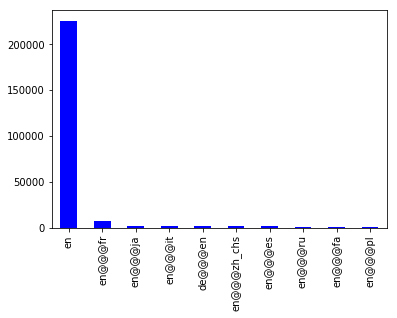

In [22]:
papers.language.value_counts().head(n=10).plot.bar(color='blue')

Not all papers are in English? What does this meaan?

In [23]:
papers.loc[papers['language']=='en@@@ja','full_title'].head()

355    On Profit-Maximizing Pricing for the Highway a...
356    On Profit-Maximizing Pricing for the Highway a...
771    Towards History-based Grammars: Using Richer M...
783    Determination of referential property and numb...
832    DECISION LISTS FOR LEXICAL AMBIGUITY RESOLUTIO...
Name: full_title, dtype: object

They are in English

## 3. Processing

We want to make the data easier to work with.

We will create a df with the topics and an index with the `arxiv_id` and another with other variables we are interested in.

Before doing that we need to deduplicate the papers. The analysis we are doing right now focuses on the diffusion of ML in other topics, for which we don't need individual institution information.

In [24]:
#papers_un means papers unique
papers_un = papers.drop_duplicates('arxiv_id')

papers_un.shape

(131189, 62)

In [25]:
#Create a topic df only including those variables referring to a topic
topics = papers_un.set_index('arxiv_id')[[x for x in papers_un.columns if 'TOPIC' in x]]

topics.head()

,TOPIC_algorithm_problem_optimization_optimization problem_solve_solution_solving_approximation_efficient_convergence,TOPIC_approach_based_technique_existing_framework_based approach_approach based_new approach_using_novel approach,TOPIC_architecture_memory_parallel_network architecture_hardware_processor_cpu_computing_gpu_core,TOPIC_bound_upper_upper bound_np_polynomial time_constant_np hard_case_time algorithm_known,TOPIC_channel_interference_transmission_wireless_receiver_rate_antenna_transmitter_mimo_transmit,TOPIC_data_data set_data structure_real data_data analysis_big data_data driven_data point_collected_synthetic data,TOPIC_different_two different_different type_three different_different approach_across different_many different_different level_using different_different way,TOPIC_dimensional_sparse_high dimensional_space_sparsity_low rank_vector_dimension_recovery_sample,TOPIC_et_al_et al_polynomial_give_whether_proof_complete_every_theorem,TOPIC_experiment_experiment show_extensive experiment_high quality_high_result indicate_quality_indicate_extensive_resolution,...,TOPIC_prove_class_game_general_player_also_hold_existence_theoretic_exists,TOPIC_real_real world_world_widely_widely used_wide_wide range_application_synthetic_commonly used,TOPIC_research_year_ha_recent_human_community_attention_recent year_challenge_become,TOPIC_service_security_mobile_device_traffic_technology_resource_attack_internet_management,TOPIC_simulation_system_simulation result_control_energy_design_controller_simulation result show_sensor_efficiency,TOPIC_social_social network_role_play_robot_dynamic_interaction_decision making_decision_autonomous,TOPIC_software_development_implementation_tool_program_open source_interface_science_programming_execution,TOPIC_state art_art_state_deep_convolutional_convolutional neural_convolutional neural network_deep learning_datasets_deep neural,TOPIC_user_account_insight_impact_analysis_provide_study_focus_issue_take account,TOPIC_web_future_social medium_medium_project_business_twitter_organization_review_content
arxiv_id,,,,,,,,,,,,,,,,,,,,,
oai:arXiv.org:0704.0002,0.428542,0.042882,0.0,0.000000,0.000000,0.000000,0.000000,0.074204,0.052545,0.0,...,0.058000,0.0,0.135712,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
oai:arXiv.org:0704.0047,0.157418,0.042882,0.0,0.000000,0.054565,0.526032,0.524284,0.020608,0.000000,0.0,...,0.028615,0.0,0.000000,0.0,0.016941,0.0,0.0,0.0,0.022756,0.0
oai:arXiv.org:0704.0050,0.206328,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.049272,0.0,0.000000,0.0,0.0,0.0,0.022756,0.0
oai:arXiv.org:0704.0098,0.000000,0.015733,0.0,0.034355,0.163856,0.000000,0.000000,0.050527,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.079938,0.0,0.0,0.0,0.022756,0.0
oai:arXiv.org:0704.0217,0.026281,0.015733,0.0,0.032564,0.472709,0.000000,0.000000,0.021966,0.000000,0.0,...,0.020230,0.0,0.000000,0.0,0.095396,0.0,0.0,0.0,0.000000,0.0


In [26]:
#These are the topics. The neural network topic are 13 and 36. Seems to be picking up more generic machine learning stuff.
for num,x in enumerate(topics.columns):
    print(str(num)+' '+x)

0 TOPIC_algorithm_problem_optimization_optimization problem_solve_solution_solving_approximation_efficient_convergence
1 TOPIC_approach_based_technique_existing_framework_based approach_approach based_new approach_using_novel approach
2 TOPIC_architecture_memory_parallel_network architecture_hardware_processor_cpu_computing_gpu_core
3 TOPIC_bound_upper_upper bound_np_polynomial time_constant_np hard_case_time algorithm_known
4 TOPIC_channel_interference_transmission_wireless_receiver_rate_antenna_transmitter_mimo_transmit
5 TOPIC_data_data set_data structure_real data_data analysis_big data_data driven_data point_collected_synthetic data
6 TOPIC_different_two different_different type_three different_different approach_across different_many different_different level_using different_different way
7 TOPIC_dimensional_sparse_high dimensional_space_sparsity_low rank_vector_dimension_recovery_sample
8 TOPIC_et_al_et al_polynomial_give_whether_proof_complete_every_theorem
9 TOPIC_experiment_e

The DL topics are 13 and 36



In [27]:
topics.columns[[13,36]]

Index(['TOPIC_learning_neural_neural network_training_machine learning_classification_trained_machine_learn_learning algorithm', 'TOPIC_state art_art_state_deep_convolutional_convolutional neural_convolutional neural network_deep learning_datasets_deep neural'], dtype='object')

**Question to consider**

* Does it make a lot of sense to consider the coefficient for a topic in Corex as a 'weight'? 
* How useful is it to distinguish between 'specialist' and 'embedded' DL papers given that many other topics don't appear to be particularly tight?

In [28]:
#And now we create a paper metadata df.
# Note that we have to set the index after subsetting (otherwise the subsetting can't find the arxiv id in the columns!)
papers_meta = papers_un[[x for x in papers_un.columns if 'TOPIC' not in x]].set_index('arxiv_id')

papers_meta.head()

,arxiv_categories,arxiv_created,arxiv_raw_summary,arxiv_raw_title,arxiv_sources,arxiv_summary,arxiv_title,citations,date,doi,...,grid_lon,institutes,journal,language,match_score,match_value,matched,title,date_parsed,year
arxiv_id,,,,,,,,,,,,,,,,,,,,,
oai:arXiv.org:0704.0002,"[math.CO, cs.CG]",1175212800000,"We describe a new algorithm, the $(k,\ell)$-pe...",Sparsity-certifying Graph Decompositions,[https://arxiv.org/abs/0704.0002],"[describe, new, algorithm, k, ell, pebble, gam...","[sparsity, certifying, graph, decomposition]",17,1241136000000,10.1007/s00373-008-0834-4,...,[-72.638139],"[smith college, university of massachusetts am...",Graphs and Combinatorics,en,1.0,Smith College,True,sparsity certifying graph decompositions,2009-05-01 01:00:00,2009
oai:arXiv.org:0704.0047,"[cs.NE, cs.AI]",1175385600000,The intelligent acoustic emission locator is d...,Intelligent location of simultaneously active ...,[https://arxiv.org/abs/0704.0047],"[intelligent, acoustic, emission, locator, des...","[intelligent, location, simultaneously, active...",8,1044057600000,10.1108/00022660310457248,...,[14.505099],[university of ljubljana],Aircraft Engineering and Aerospace Technology,en,1.0,University of Ljubljana,True,intelligent location of simultaneously active ...,2003-02-01 00:00:00,2003
oai:arXiv.org:0704.0050,"[cs.NE, cs.AI]",1175385600000,Part I describes an intelligent acoustic emiss...,Intelligent location of simultaneously active ...,[],"[part, describes, intelligent, acoustic, emiss...","[intelligent, location, simultaneously, active...",0,1167609600000,None,...,[14.505099],[university of ljubljana],arXiv preprint arXiv:0704.0050,en,1.0,University of Ljubljana,True,intelligent location of simultaneously active ...,2007-01-01 00:00:00,2007
oai:arXiv.org:0704.0098,"[cs.IT, math.IT]",1175385600000,"Sparse Code Division Multiple Access (CDMA), a...",Sparsely-spread CDMA - a statistical mechanics...,[https://arxiv.org/abs/0704.0098],"[sparse, code, division, multiple, access, cdm...","[sparsely, spread, cdma, statistical, mechanic...",24,1192147200000,10.1088/1751-8113/40/41/004,...,[-1.8895],"[aston university, hong kong university of sci...",Journal of Physics A,en,1.0,Aston University,True,sparsely spread cdma a statistical mechanics b...,2007-10-12 01:00:00,2007
oai:arXiv.org:0704.0217,"[cs.IT, math.IT]",1175472000000,Given a multiple-input multiple-output (MIMO) ...,Capacity of a Multiple-Antenna Fading Channel ...,[https://arxiv.org/abs/0704.0217?context=cs],"[given, multiple, input, multiple, output, mim...","[capacity, multiple, antenna, fading, channel,...",154,1235865600000,10.1109/TIT.2008.2011437,...,"[-87.673945, None]",[northwestern university],IEEE Transactions on Information Theory,en,1.0,Northwestern University,True,capacity of a multiple antenna fading channel ...,2009-03-01 00:00:00,2009


In [29]:
#Select columns of interest
my_columns = ['arxiv_categories','arxiv_raw_summary','arxiv_title', 'citations','year','full_title','journal','institutes']

#These columns are picking up the description of the papers, the institutes involved, the journal and the year.
#I need all these things for the analysis of 'diffusion' which is coming up.

papers_meta = papers_meta[my_columns]

papers_meta.head()

,arxiv_categories,arxiv_raw_summary,arxiv_title,citations,year,full_title,journal,institutes
arxiv_id,,,,,,,,
oai:arXiv.org:0704.0002,"[math.CO, cs.CG]","We describe a new algorithm, the $(k,\ell)$-pe...","[sparsity, certifying, graph, decomposition]",17,2009,Sparsity-certifying Graph Decompositions,Graphs and Combinatorics,"[smith college, university of massachusetts am..."
oai:arXiv.org:0704.0047,"[cs.NE, cs.AI]",The intelligent acoustic emission locator is d...,"[intelligent, location, simultaneously, active...",8,2003,Intelligent location of simultaneously active ...,Aircraft Engineering and Aerospace Technology,[university of ljubljana]
oai:arXiv.org:0704.0050,"[cs.NE, cs.AI]",Part I describes an intelligent acoustic emiss...,"[intelligent, location, simultaneously, active...",0,2007,Intelligent location of simultaneously active ...,arXiv preprint arXiv:0704.0050,[university of ljubljana]
oai:arXiv.org:0704.0098,"[cs.IT, math.IT]","Sparse Code Division Multiple Access (CDMA), a...","[sparsely, spread, cdma, statistical, mechanic...",24,2007,Sparsely spread CDMA—a statistical mechanics-b...,Journal of Physics A,"[aston university, hong kong university of sci..."
oai:arXiv.org:0704.0217,"[cs.IT, math.IT]",Given a multiple-input multiple-output (MIMO) ...,"[capacity, multiple, antenna, fading, channel,...",154,2009,Capacity of a Multiple-Antenna Fading Channel ...,IEEE Transactions on Information Theory,[northwestern university]


## 2. Analysis

### a. Paper classification
Our first stage is a descriptive analysis of DL activity: in order to do this, we need to combine the paper data and the topic mix data and then label papers based on the relative importance of the DL topics. We will then plot some descriptives.

We will start with a class that classifies papers depending on the presence of DL topics. Since we have two topics and it is not straightforward to combine coefficients into a single 'DL weight', we will classify the papers twice and then combine all the information to generate a DL variable.

In [30]:
class DlPaperClassification():
    '''
    The class takes a paper df, a topic mix and an index for the topics which contain DL.

    It has a .label_papers method that takes the topic mix and categories papers into DL groups.
    
    It also generates a categorical variable indicating if a paper is 'specialist' (dl is top category) or 
    embedded (dl is simply present)
        
    '''
    
    def __init__(self,papers,topic_mix,dl_var):
        '''
        Initialise the class with a papers file,
        A topic mix file and a list of DL categories.
        
        '''
        
        #NB we will have 
        self.papers = papers
        self.topics = topic_mix
        
        #This can be more than one
        self.dl_var = dl_var
        
        
    def label_papers(self,thres=0.2):
        '''
        We label papers into different levels of DL activity based on the weight
        in their topic mix
        -present if it is above a certain threshold
        -top if it is the top topic (not necessarily above 0.5)
        
        '''
        
        #Load all the information we need for the analysis
        papers = self.papers
        topics = self.topics
        dl_var = self.dl_var
        
        #Classify papers into categories
        #Is the DL topic present?
        dl_present = pd.Series(topics[dl_var].apply(lambda x: x>thres),
                              name='dl_present')
        
        #Is the DL topic the biggest one?
        dl_max = pd.Series(topics.idxmax(axis=1)==dl_var,name='dl_spec')
                
        #Concatenate all categories and index them (to concatenate with the papers in a moment)
        dl_all_class = pd.concat([dl_present,dl_max],axis=1)
        
        #We define an 'embed' category if papers have dl presence but are not specialised
        dl_all_class['dl_embed'] = (dl_all_class['dl_present']==True) & (dl_all_class['dl_spec']==False)
        
        dl_all_class.index = topics.index
        
        #Concatenate papers and our topic classification
        papers_lab = pd.concat([papers,dl_all_class],axis=1)
        
        #And give them a categorical variable depending on whether they are specialist or embedded
        papers_lab['dl_category'] = ['dl_spec' if x==True else 'dl_embed' if y==True else 'not_dl' for
                                      x,y in zip(papers_lab['dl_spec'],papers_lab['dl_embed'])]
    
        #Save outputs
        #Labels stores the labels we have created
        self.labels = dl_all_class
        
        #Papers_lab stores the paper metadata labelled
        self.papers_lab = papers_lab
        
        #topics_agg stores the aggregated topics (mostly for checking)
        #self.topics_agg = topic_aggregated     
        
        return(self)

In [31]:
#Run the analysis for both classes
dl_vars = [
    'TOPIC_learning_neural_neural network_training_machine learning_classification_trained_machine_learn_learning algorithm',
    'TOPIC_state art_art_state_deep_convolutional_convolutional neural_convolutional neural network_deep learning_datasets_deep neural']

#Each of the elements in dl classified is the output of the classification for a topic
dl_classified = [DlPaperClassification(papers_meta,topics,var).label_papers(thres=0.5).labels for var in dl_vars]

In [32]:
#These are the totals for both categories
pd.concat([dl_classified[0].sum(),dl_classified[1].sum()],axis=1)

,0,1
dl_present,5307,11899
dl_spec,3803,8890
dl_embed,3006,3473


In [33]:
#We create two lists of dl papers: one that appears in either topic (expansive) and one that appears in both (restrictive)

#Expansive (is in both)
papers_expansive = dl_classified[0].loc[(dl_classified[0]['dl_present']==True) | (dl_classified[1]['dl_present']==True)].index

#Restrictive (is only in one)
papers_restrictive = dl_classified[0].loc[(dl_classified[0]['dl_present']==True) & (dl_classified[1]['dl_present']==True)].index

print(len(papers_expansive))
print(len(papers_restrictive))

15602
1604


In [34]:
top_0 = dl_classified[0].loc[(dl_classified[0]['dl_present']==True)].index
top_1 = dl_classified[1].loc[(dl_classified[1]['dl_present']==True)].index

In [35]:
# Now we want to explore those papers

def sense_checker(data,text_var,sample_size=10,text_size=300):
    '''
    This function takes a dataset, draws random samples from it and prints the text so we can sense-check the quality of the matches.
    
    '''
    
    #Draw a random sample of size sample size from the data
    drawn = random.sample(list(data.index),sample_size)
    
    #return(data.loc[drawn])
    
    
    #For each element we have drawn from the sample we print the text variable up to the parameter length
    for obs in data.loc[drawn][text_var]:
        print(obs[:text_size])
        print('\n')
    



In [36]:
# print('Expansive')
# print('=========')
# sense_checker(papers_meta.loc[papers_expansive],text_var='arxiv_raw_summary')


# print('Restrictive')
# print('=========')
# sense_checker(papers_meta.loc[papers_restrictive],text_var='arxiv_raw_summary')

# print('diff')
# print('=========')
# sense_checker(papers_meta.loc[set(papers_expansive)-set(papers_restrictive)],text_var='arxiv_raw_summary')



In [37]:
papers_meta_desc = papers_meta.copy()

both = set(top_0) & set(top_1)
only_t0 = set(top_0)-set(top_1)
only_t1 = set(top_1)-set(top_0)

papers_meta_desc['dl_cat'] = ['both' if x in both else 't0' if x in only_t0 else
                             't1' if x in only_t1 else 'non_dl' for x in papers_meta_desc.index]


In [38]:
#Words by category

big_corpus = papers_meta_desc.groupby(['dl_cat'])['arxiv_raw_summary'].apply(lambda x: ' '.join([des for des in x]))

In [39]:
# Do a TFIDF of top terms in the three categories

from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(list(big_corpus),stop_words='english',ngram_range=(2,3),max_features=20000)

out = tf.fit_transform(list(big_corpus))


/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [40]:
terms = sorted([(k,v) for k,v in tf.vocabulary_.items()],key = lambda x: x[1],reverse=False)

In [41]:
out_df = pd.DataFrame(out.todense(),columns=[x[0] for x in terms],index=big_corpus.index)

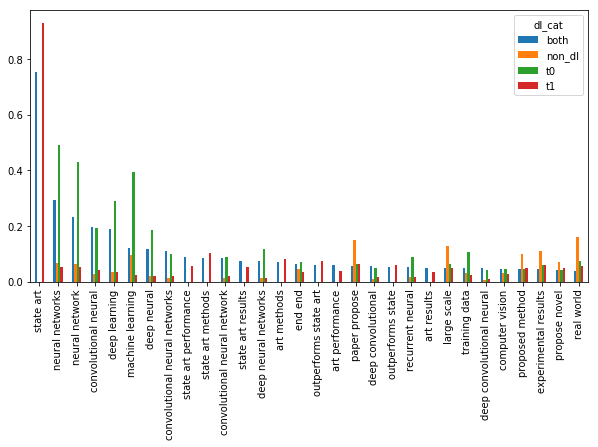

In [42]:
fig,ax = plt.subplots(figsize=(10,5))

out_df.T.sort_values('both',ascending=False)[:30].plot.bar(ax=ax)

In [43]:
# print('t0')
# print('=========')
# sense_checker(papers_meta.loc[only_t0],text_var='arxiv_raw_summary',sample_size=5,text_size=500)


# print('t1')
# print('=========')
# sense_checker(papers_meta.loc[only_t1],text_var='arxiv_raw_summary',sample_size=5,text_size=500)

# # print('diff')
# # print('=========')
# # sense_checker(papers_meta.loc[set(papers_expansive)-set(papers_restrictive)],text_var='arxiv_raw_summary')

We will focus on the expansive version

### b. Descriptive analysis

### Basic descriptives

In [44]:
# Quick: Number of papers, average year, average number of authors, average number of institutions,
# average number of citations, average number of fields

In [45]:
papers_meta.columns

Index(['arxiv_categories', 'arxiv_raw_summary', 'arxiv_title', 'citations',
       'year', 'full_title', 'journal', 'institutes'],
      dtype='object')

In [46]:
restr = papers_meta.loc[papers_restrictive]

def get_descriptives(df):
    '''
    Function to get descriptive statistics
    
    ----------
    Parameters
    ----------
    df
    
    ---------
    Returns
    ----------
    -Average number of authors, average year, average number of fields, average number of institutions, average number of citations,
    average number of citations per year
    
    
    '''    
    
    years = df['year'].mean()
    fields = df['arxiv_categories'].apply(lambda x: len(x)).mean()
    institutes = df['institutes'].apply(lambda x: len(set(x))).mean()
    #authors = df['institutes'].apply(lambda x: len(x)).mean()
    citations = df['citations'].mean()
    citations_p_year = df[['citations','year']].apply(lambda x: x['citations']/(2019-x['year']),axis=1).mean()
    
    
    out = pd.DataFrame([[years,fields,institutes,citations,citations_p_year]],
                      columns=['year_average','field_average','institute_average','citation_average','citation_p_year_average']
                      ).apply(lambda x: np.round(x,3))
    
    return(out)
    
    
    



In [47]:
papers_meta_desc = papers_meta.copy()

papers_meta_desc['dl_cat'] = ['dl' if x in papers_expansive else 'non_dl' for x in papers_meta_desc.index]

descr = papers_meta_desc.groupby('dl_cat').apply(lambda x: get_descriptives(x))

In [48]:
descr

,,year_average,field_average,institute_average,citation_average,citation_p_year_average
dl_cat,,,,,,
dl,0,2015.937,1.798,1.754,25.627,6.182
non_dl,0,2013.572,1.930,1.705,18.003,2.505


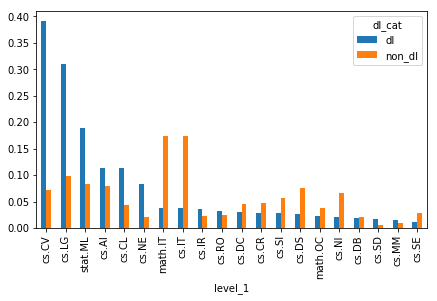

In [49]:
## More descriptive analysis

fig,ax = plt.subplots(figsize=(7,4))


pd.pivot_table(
    papers_meta_desc.groupby('dl_cat')['arxiv_categories'].apply(lambda x: flatten_freqs(x)/len(x)).reset_index(drop=False),
    index='level_1',columns='dl_cat',values='arxiv_categories').sort_values('dl',ascending=False)[:20].plot.bar(ax=ax)

Keep both

### Geography

#### i. Pre-processing: Bin into countries / regions


NB see [here](https://medium.com/@bobhaffner/spatial-joins-in-geopandas-c5e916a763f3) for a quick tutorial on spatial joins

In [50]:
#Alas, we don't have countries in these data.
import geopandas as gp
 
from shapely.geometry import Point

In [51]:
#Read the shapefile
admin_shape = gp.read_file(ext_data+'/admin_shapefile/ne_10m_admin_1_states_provinces.shp')


admin_shape['country_reg'] = [str(x)+'_'+str(y) for x,y in zip(admin_shape.iso_a2,admin_shape.name_en)]

In [52]:
country_shape = gp.read_file('../data/external/ne_10m_admin_0_countries.shp')




In [53]:
#We will use a spatial join. To do this we need to create a geopandas df with the spatial coordinates
#for each paper. We will create an individual paper id for each paper-institution pair so it's straightforward to
#merge things later

papers['paper_id'] = ['id_'+str(num)+'_'+str(match) for num,match in enumerate(papers.match_value)]

#We create a geo papers df with the lat lon
geo_paper = papers.set_index('paper_id')[['grid_lat','grid_lon']]

In [54]:
#Some of the papers here have multiple lat lons - they are from institutions with multiple locations.
#We will drop them from now.
geo_paper = geo_paper.loc[[len(x)==1 for x in geo_paper['grid_lat']]]

#Also drop papers with 'none' l
geo_paper = geo_paper.loc[[x[0]!=None for x in geo_paper['grid_lat']]]
geo_paper = geo_paper.dropna(subset=['grid_lat'])

In [55]:
len(geo_paper)-len(papers)

-24097

We lose 24,000 observations. Check with Joel what to do with these

In [56]:
#Now we turn the lat and lon into coordinates
paper_points = geo_paper.apply(lambda x: Point([x['grid_lon'][0],x['grid_lat'][0]]),axis=1)

#And create the geodataframe
papers_geodf = gp.GeoDataFrame(geo_paper,geometry=paper_points)

In [57]:
#Make sure we have the same coordinates
papers_geodf.crs= admin_shape.crs

In [58]:
#And do the spatial join - the operation indicates that we are doing a point in polygon.
papers_geographies = gp.sjoin(papers_geodf,admin_shape,op='within')

#Also with countries
papers_countries = gp.sjoin(papers_geodf,country_shape,op='within')

In [59]:
#Focus on the variables we are interested in (country and region)
papers_geo_short = pd.DataFrame(papers_geographies[['admin','name_en','country_reg']])

#Merge with the papers df
papers_all= papers.set_index('paper_id').join(papers_geo_short,how='left')


In [60]:
#Create the papers df for spatial analysis
#Variables of interest

my_vars = ['arxiv_id','title','arxiv_raw_summary','arxiv_categories',
           'journal','citations','institutes',
    'grid_lat','grid_lon','admin','name_en','country_reg','year']

papers_spat = papers_all[my_vars].dropna(subset=['name_en'])

#Remove all observations with empty geocodes
papers_spat = papers_spat.loc[[len(x)>0 for x in papers_spat['admin']]]

papers_spat['grid_lat'],papers_spat['grid_lon'] = [[x[0] for x in papers_spat[variable]] for variable in ['grid_lat','grid_lon']]


In [61]:
papers_spat.rename(columns={'name_en':'region','admin':'country'},inplace=True)

In [62]:
len(papers_spat)-len(papers)

-31271

In [63]:
papers_spat['dl_cat'] = ['dl' if x in papers_expansive else 'non_dl' for x in papers_spat.arxiv_id]

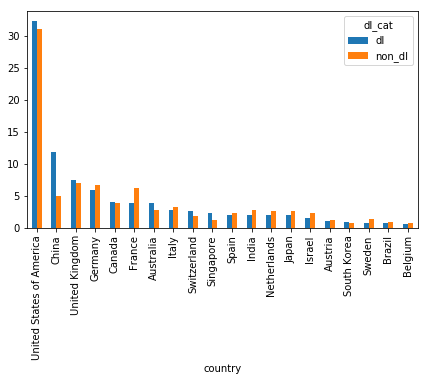

In [64]:
fig,ax = plt.subplots(figsize=(7,4))


(100*(pd.pivot_table(papers_spat.groupby(['country','dl_cat']).size().reset_index(drop=False),
               index='country',columns='dl_cat',values=0).fillna(
    0).apply(lambda x:x/x.sum(),axis=0))).sort_values('dl',ascending=False)[:20].plot.bar(ax=ax)

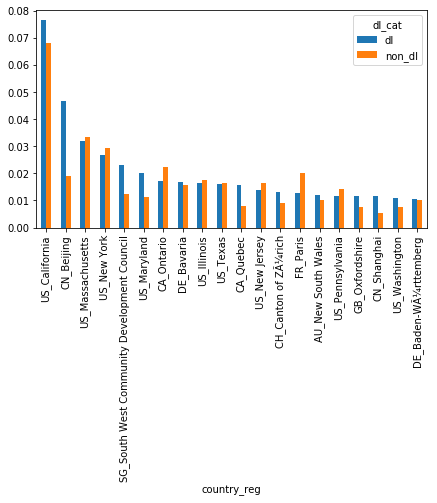

In [65]:
fig,ax = plt.subplots(figsize=(7,4))


pd.pivot_table(papers_spat.groupby(['country_reg','dl_cat']).size().reset_index(drop=False),
               index='country_reg',columns='dl_cat',values=0).fillna(
    0).apply(lambda x:x/x.sum(),axis=0).sort_values('dl',ascending=False)[:20].plot.bar(ax=ax)

### b. Descriptive analysis: GPTs

Having selected a set of papers to work with, we address our descriptive research questions.

We will build a class that addresses these questions through its methods:

In [66]:
papers_meta.citations.quantile(0.9)

25.0

In [67]:
#Functions used in the class

def get_cited_papers(data,citation_var,q=0.75):
    '''
    This function subsets a dataset returning the most cited papers of the period (based on the citation variable and the quantile)
    
    '''
    #Get the quantile
    citation_quantile = papers[citation_var].quantile(q)
    
    #Subset the data
    subset_data = data.loc[data[citation_var]>=citation_quantile]

    return(subset_data)


In [68]:
class DlPaperAnalysis_GPT():
    '''
    This class generates descriptive analyses informing our first research question: Is DL a GPT.
    
    It does so with three methods:
    
        .is_growing produces a timeseries comparing levels of activity in DL papers versus the total
        .is_spreading estimates the diffusion of DL papers in different fields
        .is_impactful estimates the citation rates for papers in different fields
    
    '''
    
    def __init__(self,papers,dl_ids):
        ''''
        This function is initialised with the full set of papers and the ids of DL papers
        
        '''
        
        #We label the data with the ids
        papers['is_dl'] = ['dl' if x in dl_ids else 'not_dl' for x in papers.index]
        
        #Store the information
        self.papers = papers
        
        #Also store the DL ids although I doubt we will do much with them
        self.dl_ids = dl_ids
        
        #Extract categories (we are only interested in computer science or statistics / ML)
        categories = [x for x in set(flatten_list(papers.arxiv_categories)) if (x[:2]=='cs') | (x=='stat.ML')]
        self.categories=categories
        
    def is_growing(self,
                   #ax,
                   year_lims=(2000,2018),thres_year=2012,high_cited=False):
        '''
        This method charts levels of activity in DL and compares the importance of DL before / after a threshold year
        
        We also give it: 
            -year_lims to subset the x axis
            -thres_year to compare the importance of DL before/after the threshold year
            -high_cited subsets the data to focus on the most highly cited papers each year (its value represents the
            position in the distribution)
        
        '''
        
        #Load papers
        papers = self.papers
        
        #Subset if we are focusing on highly cited papers
        if high_cited!=False:
            
            #This loops over years and extracts the top cited papers
            papers = pd.concat([get_cited_papers(papers.loc[papers.year==x,:],'citations',high_cited) for x in np.arange(year_lims[0],year_lims[1])])
            
            
        
        #######################
        #1. Create a timeseries
        #######################
        
        #Create timeseries (note we are subsetting this table with the year lims)
        papers_year = pd.crosstab(papers['year'],papers['is_dl']).loc[year_lims[0]:year_lims[1]]
        
        #Plot
        #papers_year.plot.bar(stacked=True,ax=ax)
    
        #Add titles etc
        
        #if high_cited==False:
         #   title = 'Number of papers in ArXiv (DL / non DL), \n {y0}-{y1}'.format(y0=str(year_lims[0]),y1=str(year_lims[1]))
        #else:
        #    title = 'Number of papers in ArXiv (DL / non DL), \n {y0}-{y1} (top {q} citations in year)'.format(y0=str(year_lims[0]),y1=str(year_lims[1]),
        #                                                                                                      q=str(100*high_cited)+'%')
        
        #ax.set_title(title,size=14)
        
        #Store information
        self.papers_year = papers_year
        
        #############################
        #2. Before / after comparison
        ###############################
        
        #Crosstabs a boolean indicating if the year is before / after the threshold and normalise over the rows
        ct = pd.crosstab(papers['year']>thres_year,papers['is_dl'],normalize=0)
        
        #We want to relabel the index of the crosstab to make the output more readable
        y = str(thres_year)
        
        ct.index=['Before '+y, 'After '+y]
        
        self.dl_shares_change= ct
        
    def is_spreading(self,
                     #ax,
                     year_lims=(2000,2017),thres_year=2012,high_cited=False,pop_categories=False):
        '''
        
        This method charts the diffusion of DL across domains. 
        One annoying aspect of this is that the papers have multiple categories with no weights. 
        We will expand the data and consider categories separately.
        
        pop_categories allows us to focus on the more popular categories of activity where we expect our share estimates to be more robust.
        
        
        #What are the key outputs:
        
        #Line chart representing DL papers as a share of total in papers with different categories
        #Line chart comparing DL papers as a share of total in different categories before / after threshold.
        
        #Note that the ax argument has two elements for the two figures we are drawing.
        
        '''
        
        #Load papers
        papers = self.papers
        
        #Subset if we have decided to focus on highly cited papers
        if high_cited!=False:
            #This loops over years and extracts the top cited papers (should probably turn this into a function)
            papers = pd.concat([get_cited_papers(papers.loc[papers.year==x,:],'citations',high_cited) for x in np.arange(year_lims[0],year_lims[1])])
            
        
        #If we are filtering to focus on popular categories
        if pop_categories!=False:
            #This extracts the top categories based on their frequency of appearance in the data
            categories = flatten_freqs(papers.arxiv_categories)[self.categories][:pop_categories].index
            
            
        #######
        #1. Create linechart of activity by category
        ########
        
        #We create a couple of containers to store the data
        #Share container stores the share of DL in total (we will use this for plotting)
        cat_share_container =[]
        
        #Cat total container stores the totals for each category. We use a dict for this
        cat_total_container = {}
        
        
        #We loop over each category of interest
        for cat in categories:
            #Subset the data to identify papers with the category
            subset = papers.loc[[cat in x for x in papers['arxiv_categories']],:]
            
            #We crosstab year vs dl categorical
            subset_year = pd.crosstab(subset['year'],subset['is_dl'])
            
            #Store the totals
            cat_total_container[cat] = subset_year
            
            #If there are any DL papers at all
            if 'dl' in subset_year.columns:
                #Calculate the share of DL papers
                subset_year['share'] = subset_year['dl']/subset_year.sum(axis=1)
                
                #We only output the share as a series named after the category (this will become the column name when we concatenate latewr)
                out = pd.Series(subset_year['share'],name=cat)
                
                #Out it comes
                cat_share_container.append(out)
            
        #Create the df filling nas and focusing on our threshold years
        category_share_df = pd.concat(cat_share_container,axis=1).fillna(0).loc[year_lims[0]:year_lims[1]]
        
        
        #Now we plot this.
        #Note that we are assuming that there are too many variables for a legend. We will probably create a cleaner version with nicer labels later.
        #category_share_df.rolling(window=3).mean().plot(legend=False,color='mediumblue',alpha=0.7,ax=ax[0])
        
        #ax[0].set_title('DL paper shares by ArXiv categories',size=14)
        #ax[0].set_ylabel('Share of all papers in category /year')
        
        #Store results
        self.cat_totals = cat_total_container
        self.cat_shares = cat_share_container
        self.cat_shares_df = category_share_df
        
        #########
        #2. Create barchart comparing two intervals
        #########

        cat_period_container = []

        #As before, we loop over categories.
        for cat in categories:
                #Subset the data to identify papers with the category
                subset = papers.loc[[cat in x for x in papers['arxiv_categories']],:]

                #We crosstab a boolean (before / after threshold) vs the dl boolean
                subset_ct = pd.crosstab(subset['year']>thres_year,subset['is_dl'],normalize=0)
                
                #This is to relabel the index (useful for the chart later)
                y = str(thres_year)
                subset_ct.index=['Before '+y, 'After '+y]
        

                #We append to the container, turning into a series so we can rename
                cat_period_container.append(pd.Series(subset_ct['dl'],name=cat))

        #Create the df
        cat_thres_df = pd.concat(cat_period_container,axis=1).T.sort_values('After '+y,ascending=True)
        
        #cat_thres_df.plot.bar(ax=ax[1])
        
        #ax[1].set_title('Change in DL shares before/after '+str(thres_year),size=14)
        #ax[1].set_ylabel('Share of all papers in category/year')
        
        
        #Store the df
        
        self.cat_thres_df = cat_thres_df
            
        
    def is_impactful(self,
                     #ax,
                     q=0.75,year_thres=2012,pop_categories=False):
        '''
        Finally, we want to check if DL papers are 'impactful' - do they tend to receive more citations than other papers in each field?
        
        To measure this we will estimate, for each category, what is the share of DL papers in total vs share of highly cited Dl papers. 
        
        We focus on papers published from a threshold year to avoid being skewed by changes in the historical distribution of papers.
        
        '''
        
        #Load papers and categories
        papers = self.papers
        categories = self.categories
        
        cit_cont=[]
        
        #If we are filtering to focus on popular categories
        if pop_categories!=False:
            #This extracts the top categories based on their frequency of appearance in the data
            categories = flatten_freqs(papers.loc[papers.year>year_thres,'arxiv_categories'])[categories][:pop_categories].index
        
        #For each category
        for cat in categories:
            try:
                #Here we have the papers since threshold (eg 2012) in the category
                subset = papers.loc[(papers.year>year_thres) & ([cat in x for x in papers['arxiv_categories']])]

                #Share of dl in all papers
                dl_all = subset['is_dl'].value_counts(normalize=True)['dl']

                #Share of dl in highly cited papers
                #We use a previous function to subset this
                subset_high_cited = get_cited_papers(subset,'citations',q)

                dl_high_cited = subset_high_cited['is_dl'].value_counts(normalize=True)['dl']

                #out = pd.Series([dl_all,dl_high_cited],index=['dl_share_all','dl_share_high_cited'],name=cat)

                #We output an index which normalises the share of high cited papers by the total. 
                #It is positive if DL papers are overrepresented amont the highly cited ones
                out = pd.Series([dl_all,dl_high_cited],index=['all','high_cited'],name=cat)


                cit_cont.append(out)
            except:
                pass
            
        #Create citation df
        citation_df = pd.concat(cit_cont,axis=1).T
        
        #return(cit_cont)
        
        #And plot it
        #citation_df.sort_values('high_cited_total_ratio',ascending=False).plot.bar(ax=ax,legend=False)
        
        #Add title
        #ax.set_title('DL paper citation \'competitiveness\' \n (papers published after {y}, top {q} citations in period))'.format(
        #    y=str(year_thres),q=str(100*q)+'%'))
        
        #And x label
        #ax.set_ylabel('(DL papers share of highly cited/ \n DL papers share of all)-1')
        
        
        #Store the df
        self.citation_impact_df = citation_df
        
        return(self)

In [69]:
def make_fig1_1(df,ax):
    '''
    Makes figure 1 for the paper
    
    '''
    
    df.plot.bar(ax=ax[0])
    (100*df.apply(lambda x: x/x.sum(),axis=1)).plot.bar(stacked=True,ax=ax[1])

    ax[1].get_legend().set_visible(False)

    ax[0].set_ylabel('Papers in arXiv',size=14)
    ax[1].set_ylabel('Papers in arXiv (% of total)',size=14)
    ax[1].set_xlabel('')

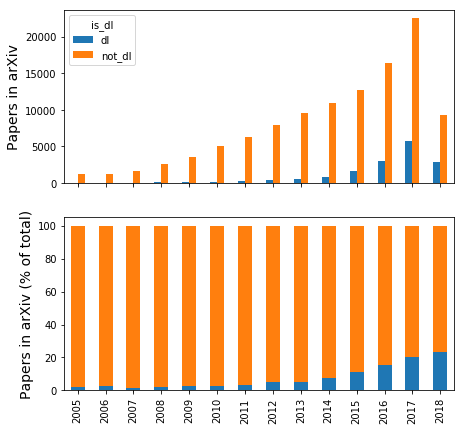

In [70]:
test = DlPaperAnalysis_GPT(papers_meta,papers_expansive)
test.is_growing(year_lims=(2005,2018))


fig,ax = plt.subplots(figsize=(7,7),nrows=2,sharex=True)

make_fig1_1(test.papers_year,ax)

Fast increase of activity in ArXiv.

DL appears to be growing at a faster rate, consistent with the 'rapidity' thesis

In [71]:
100*test.dl_shares_change

is_dl,dl,not_dl
Before 2012,3.218110,96.781890
After 2012,15.074702,84.925298


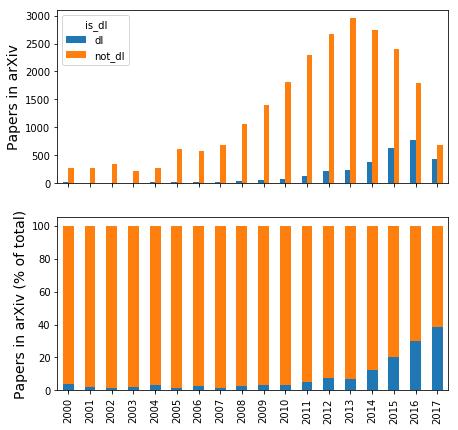

In [72]:
test2 = DlPaperAnalysis_GPT(papers_meta,papers_expansive)

test2.is_growing(high_cited=0.75)

fig,ax = plt.subplots(figsize=(7,7),nrows=2,sharex=True)

make_fig1_1(test2.papers_year,ax)



In [73]:
def make_fig_2(df1,df2,ax):
    '''
    
    Makes figure 2 (line chart plus scatter)
    
    '''
    
    
    (100*df1.rolling(3).mean()).plot(ax=ax[0],alpha=0.5,linewidth=2,color='blue')
    
    (100*df2['Before 2012']).plot(markeredgecolor='blue',marker='o',color='powderblue',ax=ax[1],markerfacecolor='blue')
    (100*df2['After 2012']).plot(markeredgecolor='orange',marker='o',color='bisque',ax=ax[1],markerfacecolor='orange')
    
    ax[1].vlines(np.arange(len(df2)),ymin=len(df2)*[0],ymax=100*df2['After 2012'],linestyle=':',)
    
    ax[1].set_xticks(np.arange(len(df2)))
    ax[1].set_xticklabels(df2.index,rotation=90)

    
    ax[0].set_ylabel('DL as % of all papers in each category')
    ax[1].set_ylabel('DL as % of all papers in each category')

    ax[0].legend().set_visible(False)
    ax[1].legend()
    
    
    
    

In [74]:
#fig,ax = plt.subplots(nrows=2,figsize=(7,6))

test.is_spreading(pop_categories=40,year_lims=(2005,2018))

#plt.tight_layout()

#plt.savefig(fig_path+'/paper_figures/figure_2_shares.pdf')


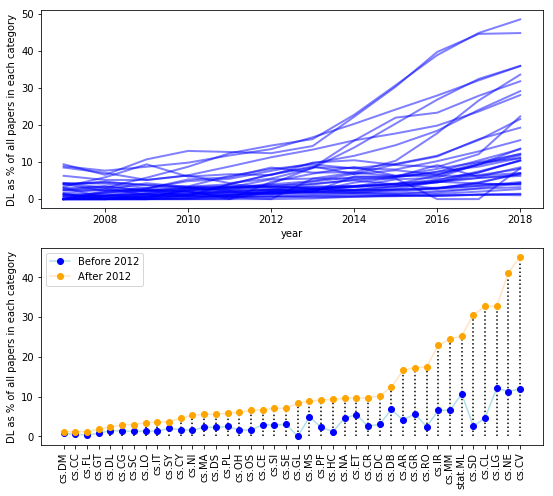

In [75]:
fig,ax = plt.subplots(figsize=(9,8),nrows=2)

make_fig_2(test.cat_shares_df,test.cat_thres_df[['Before 2012','After 2012']],ax)

#ax[1].vlines(np.arange(len(test.cat_thres_df)),ymin=len(test.cat_thres_df)*[0],ymax=test.cat_thres_df['After 2012'],linestyle=':',)


DL is becoming more important in multiple disciplines. This includes disciplines that specialise in the development of AI technologies (eg `cs.NE` = neural networks, or `cs.AI` = AI) but also others such as Computer Vision, Computation and Language, or Information Retrieval or graphics. 

**TODO** What's the discipline with the 'bump' around 2014?

In [76]:
def make_fig_3(df,ax):
    '''
    
    Scatter
    
    '''
    
    df = 100*df
    
    col = ['orange' if x['high_cited']>x['all'] else 'blue' for _,x in df.iterrows()]
    
    
    

    ax.scatter(df['all'],df['high_cited'],
               c=col,alpha=0.8,edgecolor=col)

    for x in df.index:

        
        al = df.loc[x]['high_cited']/100+0.3

        ax.annotate(s=x,xy=(df.loc[x]['all'],df.loc[x]['high_cited']),size=8,alpha=al)


    ax.plot([0,65],[0,65],linestyle=':',color='black')
    ax.set_ylim(0,65)
    ax.set_xlim(0,65)
    
    ax.set_xlabel('Share of all papers',size=12)
    ax.set_ylabel('Share of all highly cited papers',size=12)
    

In [77]:
impact_df = [test.is_impactful(year_thres=y,pop_categories=40,q=0.75).citation_impact_df for y in [2009,2012,2015]]

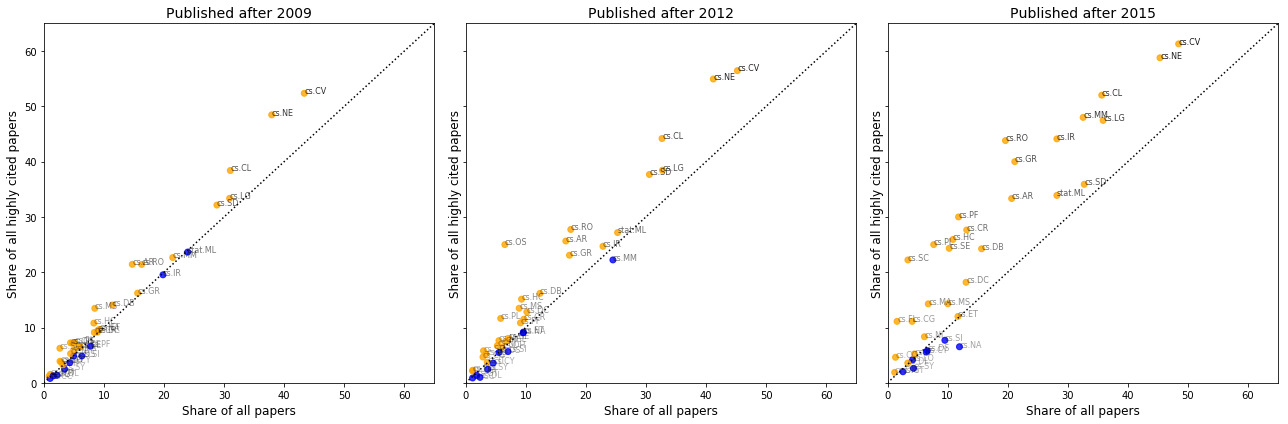

In [78]:
fig,ax = plt.subplots(figsize=(18,6),ncols=3,sharey=True)

make_fig_3(impact_df[0],ax[0])

make_fig_3(impact_df[1],ax[1])

make_fig_3(impact_df[2],ax[2])

[ax[n].set_title(f'Published after {y}',size=14) for n,y in zip([0,1,2],[2009,2012,2015])]
plt.tight_layout()

DL papers are overrepresented in the set of influential papers for most CS disciplines with only a few exceptions (software engineering and performance)

Note that some of the most popular topics for DL (in chart above) are quite low in these rankings because DL papers represent the majority of papers in them already


### Conclusion of the descriptive GPT analysis:

DL seems to fulfil all the properties of a GPT: rapid growth, diffusion in multiple areas and impact (which we proxy through citations). Now we need to analyse what this means for its geography.

## c. Geographical analysis

Having studied the development and diffusion of DL, we want to analyse their geography. What are our hypotheses here?

Our **hypothesis** is that there has been a disruption in the geography of DL: a change in the relative specialisations of countries.

How do we analyse this? 

* First we do a descriptive analysis: line charts and pre/after 2012 comparison of country 'market shares' in DL.
* Second, we do a geographical analysis using dbscan: how does the evolution of DL clustering compare with the evolution of clustering in other domains?

As before, we will write a class to do this.


#### i. Pre-processing: Bin into countries / regions


NB see [here](https://medium.com/@bobhaffner/spatial-joins-in-geopandas-c5e916a763f3) for a quick tutorial on spatial joins

We have lost a few more (2k) observations that had missing country information

#### iii. Geographical change analysis

Now we write a class that will address our spatial questions:

* What is the geographical concentration of DL research compared with other research? 
  * **TODO**: This will include Herfindahl indices and their changes, and curves of concentration
* How has the geography of DL research changed compared to other fields?
* How have the clusters evolved over time?

In [79]:
def get_high_cited_year(data,q,year_lims):
    '''
    This function extracts high cited papers by year (to control for citation times).
    TODO - put this function in all classes above
    
    '''
    #This loops over the years and extracts papers in the top quantile of activity.
    
    out = pd.concat([get_cited_papers(data.loc[data.year==x,:],'citations',
                                      q) for x in np.arange(year_lims[0],year_lims[1])])
    
    return(out)

def calculate_herfindahl(series):
    '''
    This function takes a series and returns its herfindahl index (the sum squared of the share of each observation in the total)
    
    '''
    
    herf = np.sum([(x/np.sum(series))**2 for x in series])
    return(herf)

def sort_shares_for_concentration_plot(df,cols):
    '''
    This function takes a df with shares of activity by area and returns a df ready for plotting to analyse concentration
    focusing on the columns of interest
    
    '''
    
    totals_sorted = pd.concat([
            df.sort_values(col,ascending=False)[col].reset_index(drop=True) for col in cols],axis=1)
        
    shares_sorted = totals_sorted.apply(lambda x: x/x.sum()).cumsum()
        
    return(shares_sorted)

def concentration_analysis(papers_df,level):
    '''
    This function takes a papers df and a level of analysis performs a concentration analysis which returns
    a herfindahl index which returns a concentration index for the level of activity, and a df with cumulative shares
    of activity to visualise in a plot.
    
    '''
    
    #Calculate totals by category (DL and not DL)
    totals_by_cat = pd.pivot_table(papers_df.groupby([level,'is_dl']).size().reset_index(),
                                   index=level,columns='is_dl',values=0).fillna(0)
        
    #And categories for the totals
    totals_by_cat['total'] = totals_by_cat.sum(axis=1)
        
    #Calculate Herfindahl with a function we defined before. We are only interested in DL and the total benchmark
    herf = totals_by_cat.apply(lambda x: calculate_herfindahl(x))[['dl','total']]
        
    #Store the herfindahl indices
    
        
    #To visualise these columns we creata
        
    shares_sorted = sort_shares_for_concentration_plot(totals_by_cat,['dl','total'])
    
    return([herf,shares_sorted])

In [84]:
#How we we create maps

#Merge paper metadata with paper geographical data
papers_admin = pd.DataFrame(papers_geographies[['admin','name_en','country_reg','geometry']])


papers_nat = pd.DataFrame(papers_countries[['geometry','ADMIN','NAME','SUBREGION','CONTINENT']])
papers_nat.columns = [x.lower() for x in papers_nat]

In [85]:
#Merge with the papers df
papers_admin_map= papers.set_index('paper_id').join(papers_admin,how='left')
papers_nat_map= papers.set_index('paper_id').join(papers_nat,how='left')

papers_admin_map['dl_cat'],papers_nat_map['dl_cat'] = [['dl' if x in papers_expansive else 'not_dl' for x in data] for data in [papers_admin_map.arxiv_id,
                                                                                                  papers_nat_map.arxiv_id]]

In [86]:
country_shape.columns = [x.lower() for x in country_shape.columns]

In [313]:
def geo_dash_data(papers,shape,geo_var,high_cited=0.5,thres=2012,top_locs=20,ranking=10):
    '''
    Returns data for geographical analysis:
    
    -geopandas dfs for a geographical comparison
    -barchart for before/after LQ comparison
    -Yearly LQs by location for boxplot comparison
    -Concentration of activity for concentration comparison
    
    '''
    selected_places = papers.loc[papers['dl_cat']=='dl',:].groupby(geo_var).size().sort_values(ascending=False).index[:top_locs] 
    
    
    #If we want to focus on high cited, apply the high cited function
    if high_cited!=False:
        papers = get_high_cited_year(papers,high_cited,[2007,2018])
        
    papers['thres'] = [f'pre_{thres}' if x<thres else f'post_{thres}' for x in papers['year']]
    
    ###
    #Get specialisation
    ###
    
    y_1 = get_geo_spec(shape,papers.loc[papers['year']<thres,:],geo_var)
    y_2 = get_geo_spec(shape,papers.loc[papers['year']>thres,:],geo_var)
    
    #return([y_1,y_2])
    
    ###
    #Get changes
    ###
    pre_after = papers.groupby('thres').apply(lambda x: create_lq_df(pd.pivot_table(
        x.groupby([geo_var,'dl_cat']).size().reset_index(drop=False).fillna(0),index=geo_var,columns='dl_cat',values=0))['dl'])
    
    comp = pd.pivot_table(pre_after.reset_index(drop=False),index=geo_var,columns='thres',values='dl').fillna(0).loc[selected_places]
    
 
    #return(comp)
    
    ###
    #Get volatility
    ###
    
    year_lqs = pd.pivot_table(papers.loc[papers.year>2008].groupby(['year']).apply(lambda x: create_lq_df(pd.pivot_table(
        x.groupby([geo_var,'dl_cat']).size().reset_index(drop=False).fillna(0),index=geo_var,columns='dl_cat',
        values=0))['dl']).reset_index(drop=False).fillna(0),index=geo_var,columns='year',values='dl').fillna(0)
    
    #return(year_lqs)
    
    ###
    #Get concentration 
    ###
    
    conc_dl = papers.loc[(papers.dl_cat=='dl')&(
        papers.year>2008),:].groupby('year').apply(lambda x: get_concentration(x.groupby(geo_var).size(),ranking))
    
    conc_all = papers.loc[(papers.year>2008),:].groupby('year').apply(lambda x: get_concentration(x.groupby(geo_var).size(),ranking))

    
    return([
        [y_1,y_2],
        comp,
        year_lqs,
        [conc_dl,conc_all]])

In [314]:
def get_geo_spec(shape,df,geo_var):
    '''
    Calculates specialisation by geography
    
    '''
    #We merge the shapefile with LQS by shapefile
    spec = pd.merge(shape,create_lq_df(pd.pivot_table(df.groupby([geo_var,'dl_cat']).size().reset_index(drop=False),
                   index=geo_var,columns='dl_cat',values=0).fillna(0)),left_on=geo_var,right_on=geo_var,how='left').fillna(0)
    
    spec_tots = pd.pivot_table(df.groupby([geo_var,'dl_cat']).size().reset_index(drop=False),
                   index=geo_var,columns='dl_cat',values=0).fillna(0)
    spec_tots.columns = [x+'_total' for x in spec_tots.columns]
    
    spec = spec.set_index(geo_var).join(spec_tots).fillna(0)
    
    return(spec)

def get_concentration(vector,top):
    '''
    Gets the % of activity accounted by the top x organisations
    
    
    '''
    
    share_captured = vector.sort_values(ascending=False)[:top].sum()/vector.sum()
    
    return(share_captured)

In [315]:
country_geo_outputs = geo_dash_data(papers_nat_map,country_shape,'name',ranking=5)

In [388]:
def make_map(df,variable,variable_totals,ax,cmap,shade_low=True,edge=0.5,q=0.75):
    '''
    This makes a map.
    We add an alpha depending on position in the decile of activity
 
    
    '''
    
    #df['alpha'] = pd.qcut(df[variable_totals],q=np.arange(0,1.1,0.1),duplicates='drop',labels=False)/10
    df[variable] = [lq if tot>df[variable_totals].quantile(q) else 0 for lq,tot in zip(df[variable],df[variable_totals])]
    
    
    #print(df[variable_totals].quantile(0.75))
    
    df.plot('dl',ax=ax,
            scheme='fisher_jenks',
            colormap=cmap,edgecolor='darkgrey',linewidth=edge,
            legend=True
           )

    ax.get_legend().set_bbox_to_anchor((0.19,0.5))
    ax.get_legend().set_title('Location quotient')
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

def make_geo_bar(df,ax):
    
    df.index = [x if 'South West' not in x else 'SWCDC (Singapore)' for x in df.index ]
    
    df['pre_2012'].plot(markeredgecolor='blue',marker='o',color='white',ax=ax,markerfacecolor='blue')
    df['post_2012'].plot(markeredgecolor='orange',marker='o',color='white',ax=ax,markerfacecolor='orange')
    

    col = ['orange' if x>y else 'blue' for x,y in zip(df['post_2012'],df['pre_2012'])]
    
    ax.vlines(np.arange(len(df)),ymin=df['pre_2012'],ymax=df['post_2012'],linestyle=':',color=col)
    ax.hlines(y=1,xmin=0,xmax=len(df),color='darkgrey',linestyle='--')
    
    ax.set_xticks(np.arange(len(df)))
    ax.set_xticklabels(df.index,rotation=90)

    ax.legend()
    ax.set_ylabel('Relative comparative advantage')
    #ax[1].set_ylabel('DL as % of all papers in each category')
    ax.set_xlabel('')
    
    
    
    

/usr/local/lib/python3.7/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


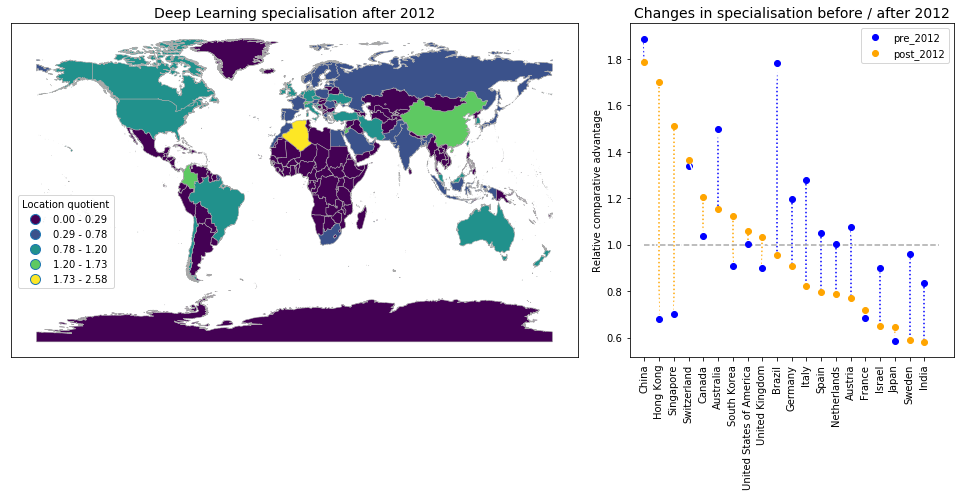

In [389]:
fig,ax = plt.subplots(figsize=(14,7),ncols=2,gridspec_kw={'width_ratios':[1.75,1]})


#make_map(country_geo_outputs[0][0],'dl',variable_totals='dl_total',ax=ax[0],cmap='Blues')
make_map(country_geo_outputs[0][1],'dl',variable_totals='dl_total',ax=ax[0],cmap='viridis')
make_geo_bar(country_geo_outputs[1].sort_values('post_2012',ascending=False),ax[1])

ax[0].set_title('Deep Learning specialisation after 2012',size=14)
ax[1].set_title('Changes in specialisation before / after 2012',size=14)

plt.tight_layout()

In [375]:
admin_geo_outputs = geo_dash_data(papers_admin_map,admin_shape,'name_en',ranking=30)

/usr/local/lib/python3.7/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


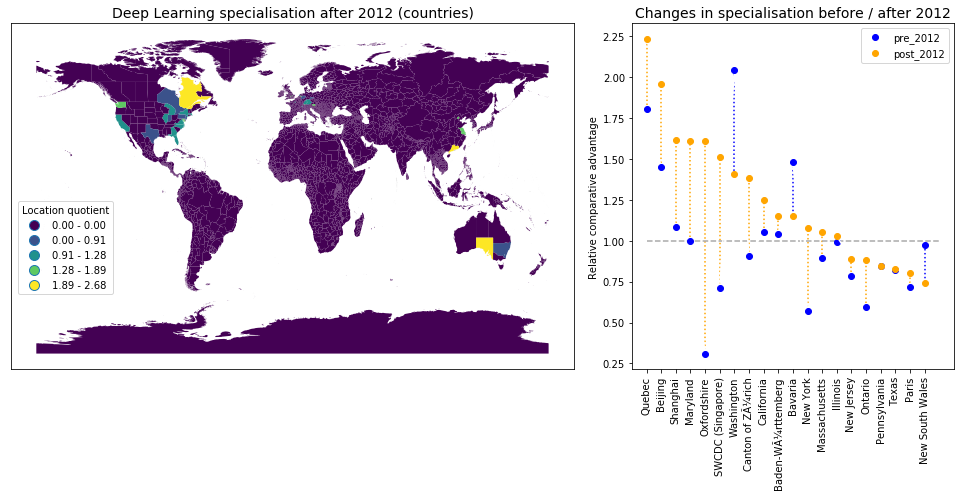

In [390]:
fig,ax = plt.subplots(figsize=(14,7),ncols=2,gridspec_kw={'width_ratios':[1.75,1]})


#make_map(country_geo_outputs[0][0],'dl',variable_totals='dl_total',ax=ax[0],cmap='Blues')
make_map(admin_geo_outputs[0][1],'dl',variable_totals='dl_total',ax=ax[0],cmap='viridis',edge=0,q=0.99)
make_geo_bar(admin_geo_outputs[1].sort_values('post_2012',ascending=False),ax[1])

ax[0].set_title('Deep Learning specialisation after 2012 (countries)',size=14)
ax[1].set_title('Changes in specialisation before / after 2012',size=14)

plt.tight_layout()

In [410]:
def volatility_concentration(df_vol,df_conc,ax,selected_locations,ylim=[50,70]):
    '''
    Volatility and concentration plots
    
    '''
    
    df_vol.loc[selected_locations].boxplot(ax=ax[0],grid=False)
    
    (100*pd.concat(df_conc,axis=1)).plot(ax=ax[1])
    
    ax[1].legend(['Deep Learning','All'])
    
    ax[1].set_ylim(ylim[0],ylim[1])

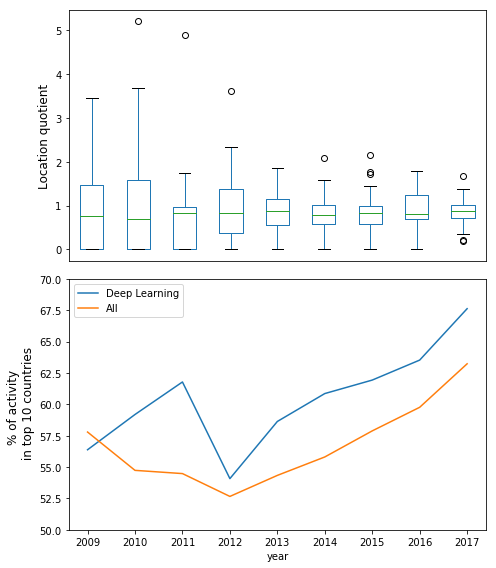

In [411]:
fig,ax = plt.subplots(nrows=2,figsize=(7,8))

selected_countries = papers_nat_map.groupby('name').size().sort_values(ascending=False)[:40].index

volatility_concentration(country_geo_outputs[2],country_geo_outputs[3],ax,selected_countries)

ax[0].set_ylabel('Location quotient',size=12)
ax[1].set_ylabel('% of activity \n in top 10 countries',size=12)

ax[0].get_xaxis().set_visible(False)
plt.tight_layout()

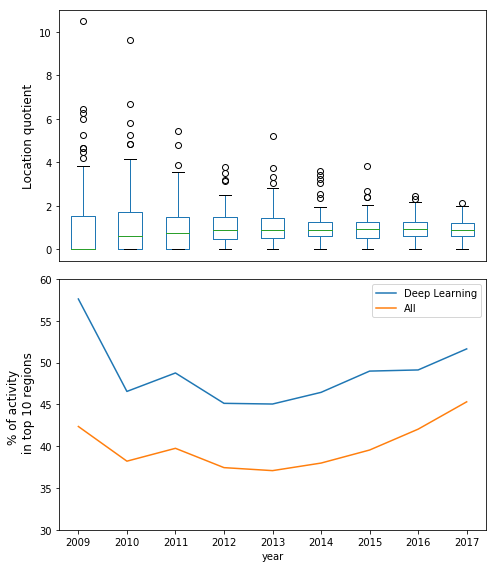

In [412]:
fig,ax = plt.subplots(nrows=2,figsize=(7,8))

selected_regions = papers_admin_map.groupby('name_en').size().sort_values(ascending=False)[:100].index

volatility_concentration(admin_geo_outputs[2],admin_geo_outputs[3],ax,selected_regions,ylim=[30,60])

ax[0].set_ylabel('Location quotient',size=12)
ax[1].set_ylabel('% of activity \n in top 10 regions',size=12)

ax[0].get_xaxis().set_visible(False)
plt.tight_layout()


In [403]:
# dl_paps = papers_admin_map.loc[(papers_admin_map['dl_cat']=='dl')]

# dl_paps.loc[(papers_admin_map['name_en']=='Oxfordshire')][['title','institutes']]

In [396]:
def get_high_cited_year(data,q,year_lims):
    '''a
    This function extracts high cited papers by year (to control for citation times).
    TODO - put this function in all classes above
    
    '''
    #This loops over the years and extracts papers in the top quantile of activity.
    
    out = pd.concat([get_cited_papers(data.loc[data.year==x,:],'citations',
                                      q) for x in np.arange(year_lims[0],year_lims[1])])
    
    return(out)

def calculate_herfindahl(series):
    '''
    This function takes a series and returns its herfindahl index (the sum squared of the share of each observation in the total)
    
    '''
    
    herf = np.sum([(x/np.sum(series))**2 for x in series])
    return(herf)

def sort_shares_for_concentration_plot(df,cols):
    '''
    This function takes a df with shares of activity by area and returns a df ready for plotting to analyse concentration
    focusing on the columns of interest
    
    '''
    
    totals_sorted = pd.concat([
            df.sort_values(col,ascending=False)[col].reset_index(drop=True) for col in cols],axis=1)
        
    shares_sorted = totals_sorted.apply(lambda x: x/x.sum()).cumsum()
        
    return(shares_sorted)

def concentration_analysis(papers_df,level):
    '''
    This function takes a papers df and a level of analysis performs a concentration analysis which returns
    a herfindahl index which returns a concentration index for the level of activity, and a df with cumulative shares
    of activity to visualise in a plot.
    
    '''
    
    #Calculate totals by category (DL and not DL)
    totals_by_cat = pd.pivot_table(papers_df.groupby([level,'is_dl']).size().reset_index(),
                                   index=level,columns='is_dl',values=0).fillna(0)
        
    #And categories for the totals
    totals_by_cat['total'] = totals_by_cat.sum(axis=1)
        
    #Calculate Herfindahl with a function we defined before. We are only interested in DL and the total benchmark
    herf = totals_by_cat.apply(lambda x: calculate_herfindahl(x))[['dl','total']]
        
    #Store the herfindahl indices
    
        
    #To visualise these columns we creata
        
    shares_sorted = sort_shares_for_concentration_plot(totals_by_cat,['dl','total'])
    
    return([herf,shares_sorted])
        
            
    


In [54]:
class DlPaperAnalysis_Spatial():
    '''
    This class implements the following methods:
    
    
    .shares compares dl shares with wider shares (a way of visualising LQs). This works with regions and countries
    .concentration compares dl geographical concentration with all papers
    .concentration_change plots changes of concentration before and after a threshold period
    .spec_change compares changes in specialisation before/after a threshold. We could also compare it with a reference field?
    .clustering performs the dbscan analysis
    
    '''
    
    def __init__(self,papers,dl_ids):
        ''''
        This class is initialised with the full set of papers and the ids of DL papers
        
        '''
        
        #We label the data with the ids
        papers['is_dl'] = ['dl' if x in dl_ids else 'not_dl' for x in papers.arxiv_id]
        
        #Store the information
        self.papers = papers
        
        #Also store the DL ids although I doubt we will do much with them
        self.dl_ids = dl_ids
        
        #Extract categories (we are only interested in computer science or statistics / ML)
        categories = [x for x in set(flatten_list(papers.arxiv_categories)) if (x[:2]=='cs') | (x=='stat.ML')]
        self.categories=categories
        
        
    def shares(self,ax,unit='country',high_cited=False,top_ranking=10,year_lims=[2007,2018]):
        '''
        This function plots shares of total papers and share of DL papers by location. As in previous
        classes, we can focus it on highly cited and only plot high activity locations.
        
        '''
        
        #Load papers
        papers = self.papers
        
        #If we want to focus on high cited, apply the high cited function
        if high_cited!=False:
            papers = get_high_cited_year(papers,high_cited,year_lims)
        
        #Now we create a df with total shares
        total_shares = papers[unit].value_counts(normalize=True)
        
        #And nother with DL shares
        dl_shares = pd.crosstab(papers[unit],papers['is_dl'],normalize=1)['dl']
        
        #Concatenate them
        all_shares = pd.concat([total_shares,dl_shares],axis=1).sort_values(unit,ascending=True)
        
        #Name columns
        all_shares.columns = ['all_papers_share','dl_papers_share']
        
        #store results
        self.shares_activity = all_shares
        
        #Plot
        all_shares[-top_ranking:].plot.barh(ax=ax)
        
        if high_cited==False:
            title = 'Share of total and DL papers by {unit}, \n {y0}-{y1}'.format(y0=str(year_lims[0]),y1=str(year_lims[1]),
                                                                                unit=unit)
        else:
            title = 'Share of total and DL papers by {unit}, \n {y0}-{y1} (top {q} citations in year)'.format(
                y0=str(year_lims[0]),y1=str(year_lims[1]),q=str(100*high_cited)+'%',unit=unit)
            
        
        return(self)
    
    
    def concentration(self,ax,unit='country',high_cited=False):
        '''
        
        This method estimates three things for the selected unit of analysis:
            -Herfindahl for the whole interval and before/after the 2012 threshold
            -Shares of activity by location in a table and a curve.
            -Shares of activity by location (change)
        
        '''
        
        #This is copied and pasted from the above. TODO: refactor
        
        #Load papers
        papers = self.papers
        
        #If we want to focus on high cited, apply the high cited function
        if high_cited!=False:
            papers = get_high_cited_year(papers,high_cited,[np.min(papers.year),np.max(papers.year)])
        
        
        #We run the previously defined function, 
        #which turns a df of totals into a df ready to be plotted for a concentration analysis
        conc = concentration_analysis(papers,level=unit)
        
        #The concentration_analysis function returns a list with two elements: herfindahl indices and shares_df for plotting
        self.herf = conc[0]
        
        shares_sorted = conc[1]
        
        ax.plot(shares_sorted)
        ax.legend(['dl','total'])
        
        #And (ugly) title
        if high_cited==False:
            title = 'Concentration of total and DL papers by {unit}'.format(unit=unit)
        else:
            title = 'Concentration of total and DL papers by {unit}, \n (top {q} citations in year)'.format(
                q=str(100*high_cited)+'%',unit=unit)
        
        ax.set_title(title,size=14)
        
        #Add labels
        ax.set_xlabel('Rank')
        ax.set_ylabel('Cumulative share of \n activity')
        
    
    def concentration_change(self,ax,unit='country',high_cited=False,threshold=2012,hline=0.75):
        '''
        This is a quite similar to the analysis above but splitting the papers into two groups (before and after the threshold)
        
        '''
        
        #Load papers
        papers = self.papers
        
        #If we want to focus on high cited, apply the high cited function
        if high_cited!=False:
            papers = get_high_cited_year(papers,high_cited,[np.min(papers.year),np.max(papers.year)])
        
        
        #We run the previously defined function, 
        #which turns a df of totals into a df ready to be plotted for a concentration analysis
        #But in this case we run it twice on different subsets of the data
        conc_t0 = concentration_analysis(papers.loc[papers['year']<threshold,:],level=unit)
        conc_t1 = concentration_analysis(papers.loc[papers['year']>threshold,:],level=unit)
        
        #Store the two sets of concentration indices
        self.herf = [conc_t0[0],conc_t1[0]]
        
        self.shares_shorted = [conc_t0[1],conc_t1[1]]
        
        shares_sorted_t0, shares_sorted_t1 = conc_t0[1],conc_t1[1]
        
        ax[0].plot(shares_sorted_t0)
        ax[1].plot(shares_sorted_t1)
        
        #Add the legend
        ax[0].legend(['dl','total'],loc='lower right')
        
        #Add titles and labels
        ax[0].set_title('Before {t}'.format(t=threshold),size=14)
        ax[1].set_title('After {t}'.format(t=threshold),size=14)
        
        ax[1].set_xlabel('Rank')
        ax[0].set_ylabel('Cumulative share of \n activity')
        ax[1].set_ylabel('Cumulative share of \n activity')
        
        #Add a hline indicating at what rank do we go over 50% of the observations
        #Find the right x values
        x_0,x_1 = [df[df['dl']>hline].index[0] for df in [shares_sorted_t0,shares_sorted_t1]]
        
        ax[0].hlines(y=hline,xmin=0,xmax=len(shares_sorted_t0),linestyle=':')
        ax[0].vlines(x=x_0,ymin=0,ymax=1,linestyle=':')
        
        ax[1].hlines(y=hline,xmin=0,xmax=len(shares_sorted_t1),linestyle=':')
        ax[1].vlines(x=x_1,ymin=0,ymax=1,linestyle=':')
        
    
    
    def spec_changes(self,ax,unit='country',high_cited=False,top_ranking=10,year_lims=[2007,2018],window=4):
        '''
        Here we compare the evolution of specialisation (relative overrepresentation of papers by country).
        It is a linechart.
        We add a 'window' parameter to the previous, to smooth the lines.
        
        '''
        
        #Load papers
        papers = self.papers
        #Focus on years of interest
        papers = papers.loc[(papers.year > year_lims[0]) & (papers.year < year_lims[1]),:]
        
        #If we want to focus on high cited, apply the high cited function
        if high_cited!=False:
            papers = get_high_cited_year(papers,high_cited,year_lims)
        
        #Identify top locations
        locations = papers[unit].value_counts()[:top_ranking].index
        
        #Now we estimate LQs by year and paper
        #This estimates the LQ
        papers_year = papers.groupby('year').apply(lambda x: create_lq_df(pd.crosstab(x[unit],
                                                                        x['is_dl'])))
        #Now we pivot the data
        spec_wide = pd.pivot_table(papers_year, index='year',columns=unit,values='dl')[locations]
        
        #Store it
        self.spec_place = spec_wide
        
        spec_wide.rolling(window=window).mean().plot(ax=ax,linewidth=3)
        ax.legend(bbox_to_anchor=(1,1),title=unit)
        
        ax.hlines(y=1,xmin=year_lims[0]+4,xmax=year_lims[1]-1,linestyle=':')
        
        #Add titles as before. Quite convoluted
        if high_cited==False:
            title = 'Comparative advantage in DL by {unit}, \n {y0}-{y1}, \n {w}-year moving averages'.format(
                y0=str(year_lims[0]),y1=str(year_lims[1]),unit=unit,w=window)
        else:
            title = 'Comparative advantage in DL by {unit}, \n {y0}-{y1} (top {q} citations in year), \n {w}-year moving averages'.format(
                y0=str(year_lims[0]),y1=str(year_lims[1]),q=str(100*high_cited)+'%',unit=unit,w=window)
        
        
        #Set title
        ax.set_title(title,size=14)
    
        
    def spec_thres(self,ax,unit='country',high_cited=False,top_ranking=20,year_threshold=2012):
        """
        This creates a barchart comparing comparative advantages before / after a threshold year
        
        """
        
        #Load papers
        papers = self.papers
        
        #Add variable for subsetting
        papers['threshold_year'] = ['pre_'+str(year_threshold) if y<year_threshold else 'post_'+str(year_threshold) for
                                   y in papers['year']]
        
        
        locations = papers[unit].value_counts()[:top_ranking].index
        
        #If we are working with highly cited papers
        #Split into two years, apply the get_cited_papers and combine
        if high_cited != False:
            papers =papers.groupby('threshold_year').apply(lambda x: get_cited_papers(
                x,'citations',high_cited)).reset_index(drop=True)
        
        #Now we calculate the LQs for both years.
        lqs = papers.groupby(
            'threshold_year').apply(lambda x: create_lq_df(pd.crosstab(x[unit],x['is_dl']))).reset_index(drop=False)
        
        
        #This creates the table for plotting
        specs_wide = pd.pivot_table(lqs,
               index='threshold_year',columns=unit,values='dl')[locations].T.sort_values(
            'post_'+str(year_threshold),ascending=False).plot.bar(ax=ax)
        
        
        self.spec_wide = lqs
        
        #And the labe;s
        ax.legend(bbox_to_anchor=(1,1),title='Period')
        
        ax.hlines(y=1,xmin=0,xmax=top_ranking,linestyle=':')
        
        #Add titles as before. Quite convoluted
        if high_cited==False:
            title = 'Comparative advantage in DL by {unit}, \n before and after {y}'.format(y=str(year_threshold),
                                                                                            unit=unit)
        else:
            title = 'Comparative advantage in DL by {unit}, \n before and after {y} (top {q} citations in year)'.format(
               y=str(year_threshold),unit=unit,q=str(100*high_cited)+'%')
        
        
        #Set title
        ax.set_title(title,size=14)        

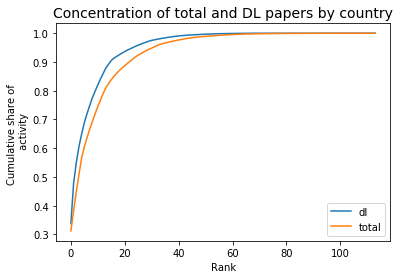

In [127]:
#Initialise class
test_2 = DlPaperAnalysis_Spatial(papers_spat,papers_restrictive)

#Plot concentratioj
fig,ax =plt.subplots()
test_2.concentration(ax,unit='country',high_cited=False)

There is more concentration in DL than in the CS population overall

The evolution of concentration is interesting: there has been an increase of concentration at the top (the top locations have gained importance but also an 'stretching' of the middle (a decrease in concentration lower in the distribution, consistent with the idea of a broadening of activity / increase in volatility) 

**Now we want to focus on changes in concentration**

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



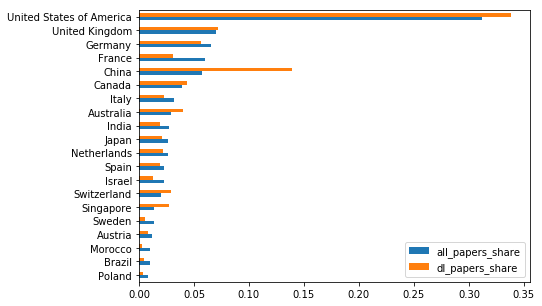

In [128]:
#Visualise shares of activity by country
fig,ax = plt.subplots(figsize=(7,5))

test_2.shares(ax,unit='country',top_ranking=20,high_cited=False)

This chart shows that some countries such as US, China, Canada and Switzerland are overrepresented in DL while others such as France. Germany and Italy are underrepresented

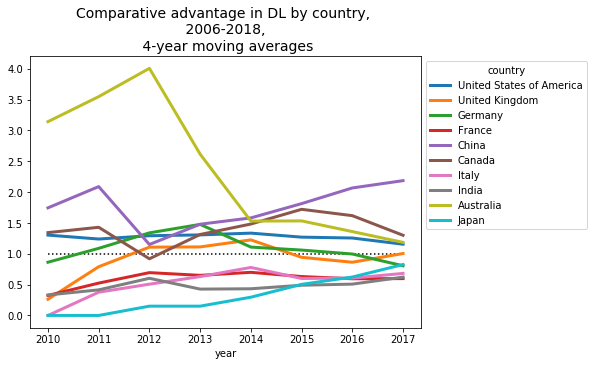

In [129]:
fig,ax = plt.subplots(figsize=(7,5))

test_2.spec_changes(ax,high_cited=False,year_lims=(2006,2018))

Year on year figures are quite noisy. They suggest quite a lot of volatility in DL activity although we would need to compare to another field in order to establish this for sure. This is to be done.

It would be interesting to understand what happened with Australia and China at the beginning of the period


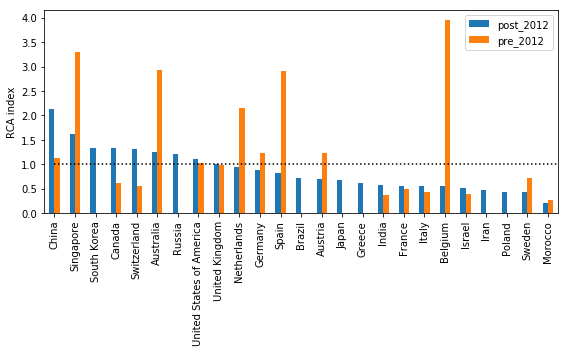

In [130]:
fig,ax = plt.subplots(figsize=(8,5))

test_2.spec_thres(ax,unit='country',high_cited=0.5,top_ranking=25)

ax.set_xlabel('')
ax.set_title('')
ax.set_ylabel('RCA index')
ax.legend(loc='upper right')

plt.tight_layout()

plt.savefig(fig_path+'/paper_figures/figure_4_spec_change.pdf',bbox_to_inches='tight')


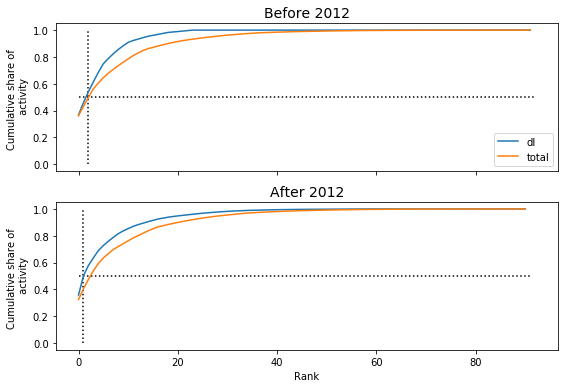

In [131]:
#Plot concentration changes

fig,ax =plt.subplots(nrows=2,figsize=(8,5.5),sharey=True,sharex=True)
test_2.concentration_change(ax,unit='country',high_cited=0.5,threshold=2012,hline=0.5)

#fig.suptitle('Changes in concentration')

plt.tight_layout()

plt.savefig(fig_path+'/paper_figures/figure_5_concentration_change.pdf',bbox_to_inches='tight')


In [141]:
#Compare shares of the top countries before / after 2012 (for the paper)
conc_change_dl = pd.concat([test_2.shares_shorted[0]['dl'],test_2.shares_shorted[1]['dl']],axis=1)

conc_change_dl['conc_change'] = conc_change_dl.iloc[:,1]-conc_change_dl.iloc[:,0]
conc_change_dl.head()

,dl,dl,conc_change
0,0.367491,0.358238,-0.009253
1,0.459364,0.502312,0.042948
2,0.540636,0.579216,0.038580
3,0.614841,0.635678,0.020837
4,0.685512,0.689462,0.003950


In [133]:
test_2.herf[1]['dl']/test_2.herf[0]['dl']-1
test_2.herf[1]['total']/test_2.herf[0]['total']-1

-0.14483544223691436

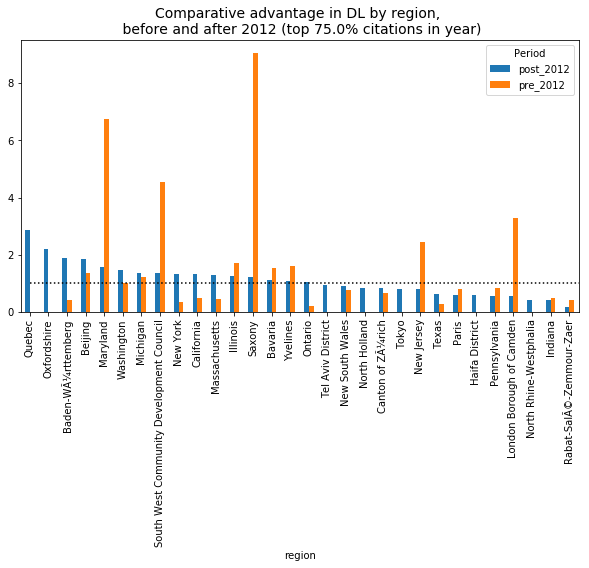

In [134]:
fig,ax = plt.subplots(figsize=(10,5))

test_2.spec_thres(ax,unit='region',high_cited=0.75,top_ranking=30)

We see some evidence of churn when we compare before / after 2012. Some countries such as China, Hong Kong, Singapore and Canada gain a lot of visibility while others such as Switzerland, Netherlands, Japan and Spain see a relative decline. When we look at the regional picture we see some spectacular changes in some places such as Beijing, Baden-Wurttemberg, New York or Ontario.

#### iii. Clustering analysis

The analysis above is quite coarse and does not take into account spatial patterns of concentration. We will explore that question using the DBSCAN algorithm, which identifies clusters in a data-driven way by looking for high density groups of observations within a set radius. We are interested in quantifying geograpnical disruption: how does the geography of activity change between periods?

Note that given the big changes in activity in Dl it is quite difficult to compare before/after clusters (the minimum cluster sizes and spans are likely to change). For that same reason, it is hard to compare dl with non dl.

What we will do is compare clustering trends for a 'high dl' and 'low dl' category. These are identified based on the relative importance of DL papers in them.

We will compare changes in activity between these two groups: do the clusters in high DL activity display more volatility than those in low DL activity?


**Implementation**

Create a class `DlPaperAnalysisCluster` which estimates the clusters with a set number of parameters and generates those statistics.
We will then do grid search over different parameters and compare the results. 

We initialise the class with all the data.

-We implement a `.segment` method to automatically identify, inside the top X ArXiv categories, those that are 'high DL' and those that are 'low DL'.
-We implement a method called `.time_cluster_comp` which compares the clusters between two periods.
-We implement a method called `.disc_cluster_comp` which compares clusters in disciplines

All the results are stored so that we can map the results.



In [63]:
#Some imports and changes
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

pd.options.mode.chained_assignment = None

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [64]:
#A bunch of functions we will need to use
def dbscan(data,coords,epsilon,min_samples):
    '''
    the function dbscan calculates the clusters.
    coords is a list with the lon and lat
    
    '''
    #Create the matrix for estimation
    #coords = data.as_matrix(columns=[coords[0],coords[1]])
    coords = data[[coords[0],coords[1]]].values
    
    #Parameters
    kms_per_radian = 6371.0088
    
    #Estimate epsilon as radians (we use the Haversine metric to measure distances in a sphere)
    epsilon = 13 / kms_per_radian
    
    #Initialise cluster
    db = DBSCAN(eps=epsilon, min_samples=min_samples, 
                algorithm='ball_tree', 
                metric='haversine').fit(np.radians(coords))
    
    return(db)
    
def cluster_report(data,cluster_fit):
    '''
    This function returns a report for the clusters
    
    '''
    #Output container
    output=[]
    
    #Number of clusters is the set of the labels -1 (removing the non-cluster label)
    number_clusters = len(set(cluster_fit.labels_))-1
    #And append to outputs
    output.append(number_clusters)
    
    #Label the data with the cluster labels
    data['cluster'] = cluster_fit.labels_
    
    #Remove the observations outside of clusters
    data_in_cluster = data.loc[data['cluster']!=-1,:]
    
    #Generate the point coordinates in clusters for mapping
    coords_in_cluster = data_in_cluster[['grid_lon','grid_lat']]
    #And append to output
    output.append(coords_in_cluster)
    
    
    #Generate the convex hull for each cluster
    #We need to get the points for each cluster
    data_in_cluster['points'] = [(c1,c2) for c1,c2 in zip(data_in_cluster['grid_lon'],
                                                          data_in_cluster['grid_lat'])]
    
    #Also create a geopoints df so we can do the point in polygon thing later
    geo_points = gp.GeoDataFrame(Point(x,y) for x,y in zip(data_in_cluster['grid_lon'],
                                                           data_in_cluster['grid_lat']))
    
    #print(geo_points)
    geo_points.set_geometry(0,inplace=True)
    output.append(geo_points)
    
    
    ch_store = []
    
    #Then we group over the cluster (note that we have already excluded the no-cluster set)
    for c in set(data_in_cluster['cluster']):
        #We turn each of the coordinates in the cluster into an array of points
        points = np.array(data_in_cluster.loc[data_in_cluster['cluster']==c,['grid_lon','grid_lat']])
        
        #We turn those points into polygons and put them in a geoseries with the convex hull (envelope)
        #This way we can look for the clusters 
        ch = gp.GeoSeries(Polygon(points)).convex_hull
        
        ch_store.append(ch)
    
    #Output this as a geodf
    geo_df = gp.GeoDataFrame(ch_store)
    geo_df.set_geometry(0,inplace=True)
    
    output.append(geo_df)
    
    #Now I want the cities in each cluster (we focus on the top 5 cities)
    cities_in_clusters = data_in_cluster.groupby('cluster')['country_reg'].apply(lambda x: x.value_counts()[:5])
    #And append to output
    output.append(cities_in_clusters)
    
    #Now I want the % of activity in the clusters
    activity_in_cluster_share = len(data_in_cluster)/len(data)
    #And append to output
    output.append(activity_in_cluster_share)
    
    #And the % of highly cited papers in clusters
    high_cited_in_cluster_share = len(data_in_cluster.loc[data_in_cluster['high_cited']==True,:])/len(data.loc[
        data['high_cited']==True,:])
    
    output.append(high_cited_in_cluster_share)
    
    return(output) 

def cluster_comparison(report_1, report_2):
    '''
    This function checks how many points from the second cluster set are in the first cluster set and vice versa.
    It is a measure of volatility. If all points in the second cluster set where in the first, then we would have perfect stability.
    If the opposite, we have perfect disruption.
    
    '''
    
    #How many points in 2 would have been present in 1?
    #geodf with period 1 polys
    polys_1 = report_1[3]
    
    #geodf with period 2 points
    points_2 = report_2[2]
    
    polys_1.crs=points_2.crs
    
    #Do the join
    spatial_join = gp.sjoin(polys_1,points_2,how='inner',op='contains')
    
    #What percentage of papers in period 2 clusters are not in a period 1 cluster?
    coverage = len(spatial_join)/len(points_2)
    
    
    #What regions in period 2 clusters are not in period 1 clusters and viceversa
    #Find the unique regions present in the clusters
    reg_1,reg_2 = [set(rep[4].reset_index(drop=False)['level_1']) for rep in [report_1,report_2]]
    
    #Estimate exits and entries
    exits = reg_1 - reg_2
    entries = reg_2 - reg_1
    
    #Save and return
    exits_entries = [exits,entries]
    
    return([coverage,exits_entries])

In [65]:
class DlPaperAnalysisCluster():
    '''
    This class estimates geo clusters in a paper database a set number of parameters and generates those statistics.
    We will then do grid search over different parameters and compare the results. 

    We initialise the class with all the data.
        -.segment identifies the comparison sets: papers in high DL arXiv categories and low DL arXiv categories.
        We think of them as treatments and controls.
        
        -.cluster_changes compares changes in clustering between disciplines, over two periods
        
        #-.disc_cluster_comp` compares clusters in disciplines
    
    All the results are stored so that we can map the results.
    '''
    
    def __init__(self,papers):
        '''
        Initialise with the papers. Note that these papers have already been classified into DL / non-DL
        
        '''
        #Store papers
        self.papers = papers
        
        #Extract categories (we are only interested in computer science or statistics / ML)
        categories = [x for x in set(flatten_list(papers.arxiv_categories)) if (x[:2]=='cs') | (x=='stat.ML')]
        
        cat_freqs = flatten_freqs(papers['arxiv_categories'])[categories]
        
        self.categories=cat_freqs.index[cat_freqs>10000]
        
    def segment(self,pop_categories=20,levels=[0.33,0.1]):
        '''
        We want to identify a 'treatment' and 'control' group. The treatment are arXiv categories with high level of DL activity.
        The control are arXiv categories with low level . of DL activity
        
        '''
        papers = self.papers
        categories = self.categories
        

        cat_store = []
        
            
        #For each category, calculate the DL paper share
        for cat in categories:
                #Subset the data to identify papers with the category
                subset = papers.loc[[cat in x for x in papers['arxiv_categories']],:]

                #We crosstab a boolean (before / after threshold) vs the dl boolean
                subset_ct = subset['is_dl'].value_counts(normalize=True)
                subset_ct.name=cat
                
                #Append
                cat_store.append(subset_ct)
                
        
        #Identify categories high and low cluster chare
        self.cat_groups = [[x.name for x in cat_store if x['dl']>levels[0]],[x.name for x in cat_store if x['dl']<levels[1]]]
        
   
    
    def cluster_periods(self,threshold=2012,min_samples=200,epsilon=10,high_cited=False,
                          citation_threshold=0.75,
                          is_dl=True):
        '''
        Inputs:
        -This method identifies clusters in the data comparing before and after the threshold date.
        -It takes parameters for DBSCAN (minimum number of samples and the distance)
        -It focuses on all papers (we can instead set this to high cited) and dl papers
        
        Outputs:
        -Cluster labels
        -Collection of points for mapping (removing 'noise clusters')
        -Shares of t1 activity in t0 clusters (calculated using convex hull which gives us the envelop containing all points) 
        and viceversa.
        
        '''
        
        #Initialise papers
        papers = self.papers
        categories = self.cat_groups
        
        #If we are focusing on highly cited papers
        #if high_cited!=False:
        #    papers = get_high_cited_year(papers,high_cited,[min(papers['year']),max(papers['year'])])
            
        #We want to label highly cited papers
        high_cited_ids = get_high_cited_year(papers,citation_threshold,[min(papers['year']),max(papers['year'])]).index
        papers['high_cited'] = [True if x in high_cited_ids else False for x in papers.index]
        
        results = {}
        
        #We loop over the two sets of categories
        #For each category group (high or low categories)
        for cat_group in categories:
            #For each category in the group
            for cat in cat_group:
                #Tracker
                print(cat)
                #Identify papers in group
                subset = papers.loc[[cat in arxiv_cat for arxiv_cat in papers['arxiv_categories']]]
                
                #Split into papers in t0 and papers in t1. Note that this excludes the threshold year as a 'boundary'
                subset_0 = subset.loc[subset['year']<threshold]
        
                subset_1 = subset.loc[subset['year']>threshold]
                
                #Fit the clustering algorithm for the two subsets in the data and generate the reports
                db_report_0,db_report_1 = [cluster_report(subset,dbscan(subset,coords=['grid_lon','grid_lat'],
                                                                epsilon=epsilon,
                                                                min_samples=min_samples)) for subset in [subset_0,subset_1]]
                
                #And now we want to compare the clusters before and after.
                #How much activity in the second period is captured by clusters identified in the first period
                compare_1 = cluster_comparison(db_report_0,db_report_1)
                
                
                results[cat]=[[db_report_0,db_report_1],compare_1]
                #return([db_report_0,db_report_1])
                
        self.cluster_comparisons = results   
        
    def visualise_differences(self,ax):
        '''
        Here we want to visualise some of the differences in the data.
        Boxplots that compare:
            -Share of activity in period 2 captured by clusters from period 1.
            -Share of activity in period 1 captured by clusters from period 2.
            -Cluster difference between period 1 and period 2
            -Increase in the share of activity captured by clusters in different periods
            -Increase in the share of citations captured by clusters in different periods
        
        '''
        
        #Load information
        comps = self.cluster_comparisons
        high_dl_cats = self.cat_groups[0]
        
        
        #Compare t0 coverage in t1 between both groups.
        discs = pd.Series({k:v[1][0] for k,v in comps.items()})
        
        #Compare change in cluster numbers between period 1 and period 2
        n_change = pd.Series({k:v[0][1][0]/v[0][0][0] for k,v in comps.items()})
        
        #Compare change in concentration accounted by top clusters
        conc_change = pd.Series({k:v[0][1][-2]/v[0][0][-2] for k,v in comps.items()})
        
        #Compare change in high citations accounted by top clusters
        cit_change = pd.Series({k:v[0][1][-1]/v[0][0][-1] for k,v in comps.items()})
        
        #Concatenate in a single df.
        cluster_comp_df = pd.concat([discs,n_change,conc_change,cit_change],axis=1)
        
        
        self.cluster_comp = cluster_comp_df
        
        cluster_comp_df.columns = [
            'Initial cluster coverage','Cluster expansion','Concentration change','Citation concentration \n change']
        
        #Label the df
        cluster_comp_df['high_dl'] = [x in high_dl_cats for x in cluster_comp_df.index]
        

        #Plot all these in 4 rows
        ax[0][0].boxplot([cluster_comp_df.loc[cluster_comp_df['high_dl']==True,
                                              cluster_comp_df.columns[0]],
                          cluster_comp_df.loc[cluster_comp_df['high_dl']==False,
                                     cluster_comp_df.columns[0]]])
        
        ax[0][0].set_ylabel(cluster_comp_df.columns[0],size=10)
        ax[0][0].set_title('PANEL A:\n'+cluster_comp_df.columns[0],size=12)
        
        ax[0][1].boxplot([cluster_comp_df.loc[cluster_comp_df['high_dl']==True,
                                              cluster_comp_df.columns[1]],
                          cluster_comp_df.loc[cluster_comp_df['high_dl']==False,
                                     cluster_comp_df.columns[1]]])
        
        ax[0][1].set_ylabel(cluster_comp_df.columns[1],size=10)
        ax[0][1].set_title('PANEL B:\n'+cluster_comp_df.columns[1],size=12)
        
        ax[1][0].boxplot([cluster_comp_df.loc[cluster_comp_df['high_dl']==True,
                                              cluster_comp_df.columns[2]],
                          cluster_comp_df.loc[cluster_comp_df['high_dl']==False,
                                     cluster_comp_df.columns[2]]])
        
        ax[1][0].set_ylabel(cluster_comp_df.columns[2],size=10)
        ax[1][0].set_title('PANEL C:\n'+cluster_comp_df.columns[2],size=12)
        
        ax[1][1].boxplot([cluster_comp_df.loc[cluster_comp_df['high_dl']==True,
                                              cluster_comp_df.columns[3]],
                          cluster_comp_df.loc[cluster_comp_df['high_dl']==False,
                                     cluster_comp_df.columns[3]]])
        
        ax[1][1].set_ylabel(cluster_comp_df.columns[3],size=12)
        ax[1][1].set_title('PANEL D:\n'+cluster_comp_df.columns[3],size=12)
        
        
        
        
        #for num in np.arange(0,4):
        #    ax[num].boxplot(
        #        [cluster_comp_df.loc[cluster_comp_df['high_dl']==True,
        #                             cluster_comp_df.columns[num]],
        #         cluster_comp_df.loc[cluster_comp_df['high_dl']==False,
        #                             cluster_comp_df.columns[num]]])
        #    
        #    ax[num].set_xticklabels(['High DL categories','Low DL categories'])
        #    ax[num].set_title(cluster_comp_df.columns[num],size=14)
        
        
        
        return(self)

In [66]:
#Run the test and segment the categories based on their share of DL papers

papers_clust = test_2.papers

test_cl = DlPaperAnalysisCluster(papers_clust)
test_cl.segment(levels=[0.4,0.1])

In [67]:
#These are the test groups
test_cl.cat_groups

[['cs.LG', 'cs.CV', 'stat.ML'], ['cs.NI', 'cs.DS', 'cs.LO', 'cs.IT', 'cs.DM']]

In [68]:
test_cl.cluster_periods(min_samples=50,epsilon=20)

cs.LG
cs.CV
stat.ML
cs.NI
cs.DS
cs.LO
cs.IT
cs.DM


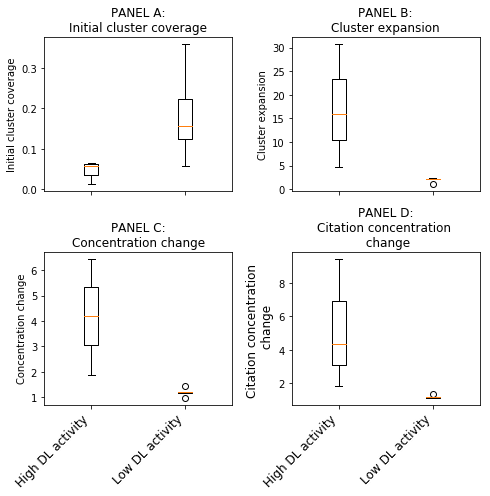

In [69]:
fig,ax = plt.subplots(figsize=(7,7),nrows=2,ncols=2,sharex=True)

test_cl.visualise_differences(ax)

ax[1][0].set_xticklabels(['High DL activity','Low DL activity'],size=12,rotation=45,ha='right')
ax[1][1].set_xticklabels(['High DL activity','Low DL activity'],size=12,rotation=45,ha='right')

plt.tight_layout()

plt.savefig(fig_path+'/paper_figures/figure_6_micro_comparison.pdf',bbox_to_inches='tight')

What does all the above mean? It means that:
* The initial clusters identified in the arXiv categories with more DL activity tend to cover less of subsequent activity than the in arXiv categories with less DL activity: **There has been a dislocation of activity away from initial clusters**
* There has been a significant expansion in the number of identified clusters in categories with high DL activity by comparison to what happened in categories with low DL activity. **New entrants**
* New clusters have started capturing a much bigger share of the research activity **Concentration** (shakeout?)
* New clusters have started capturing a much bigger share of the high-citation activity **Concentration of innovation** (shakeout)


    

### Next steps (TODO)

* Check robustness of the analysis above: to which extent are the above changes driven by rapid growth? Can we find low DL categories which experienced similar growth rates? Are they also different in their performance?
* Visualise the changes above. Could we have maps showing the clusters in the first period and the second period?

## 3. Multivariate analysis (TODO)

We have evidenced the GPT nature of DL and also the disruption it has created in existing research networks. Here we focus on explaining the drivers for change. What predicts if a region is part of one of the new clusters?

* The outcome is whether a region contains a cluster or not.
* The predictors are whether the region contained a cluster before or not, and its cognitive and business diversity based on arXiv and CrunchBase, as well as the total levels of research and industrial activity
* We focus the analysis on regions in the top 50% of CS activity (locations 'in the game').
* We include a control for China

Our hypothesis:
* Those locations with higher levels of knowlegde supply and demand diversity are more likely to become successful clusters. This suggests the importance of complex network effects in the development of GPTs, and the localised nature of its spillovers
* These effects will hold after introducing a control for China suggesting that although national strategies are important for the development of clusters, they need to be complemented with local capabilities and networks

#### 0. preliminaries



In [70]:
#Create target and features
#We will use region indices to keep track of variables

#DF to use ('mv_data' means multivariate data)
mv_data = papers_clust.loc[papers_clust['region']!='',:]


##### Load the CrunchBase data

This includes loading the CB metadata and the geocoded data and classifying companies into regions using the admin shapefile


In [71]:
#Load the CrunchBase data (which lives in the 'grant data')
cb_data = pd.read_csv(ext_data+'/csv_export.tar.gz',compression='gzip')

#Drop observations for which we have no role or address
cb_data.dropna(axis=0, subset=['roles','address','uuid','founded_on'],inplace=True)
cb_data['is_comp'] = ['company' in x for x in cb_data.roles]

#Focus on companies
cb_comps = cb_data.loc[cb_data['is_comp']==True,:]

#TODO: turn these point in polygon operations into a function.

#Load the geocoded data
cb_geo_sample = pd.read_csv(ext_data+'/cb_geolocated_full.csv')

#Now we turn the lat and lon into coordinates
cb_points = cb_geo_sample.set_index('uuid')[['lng','lat']].apply(lambda x: Point([x['lng'],x['lat']]),axis=1)

#Create geodataframe
cb_geodf = gp.GeoDataFrame(geometry=cb_points)

#Combine with the shapefile
cb_geodf.crs = admin_shape.crs

#And do the spatial join - the operation indicates that we are doing a point in polygon.
cb_geographies = gp.sjoin(cb_geodf,admin_shape,op='within')

#Put the regions back into the company data
cb_comps_geo = cb_comps.set_index('uuid').join(cb_geographies['country_reg'])

#And rename them with 'region_geo' (there is already a 'region' variable in CrunchBase)
#cb_comps_geo.rename(columns={'name_en':'region_geo'},inplace=True)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### i. Targets: Identify DL clusters

This will use the DBSCAN method. We can run it multiple times with different hyperparameters and identify the regions that contain clusters. This gives us a built-in test of robustness.

In [72]:
#Target container
target = pd.DataFrame(index=set(mv_data['country_reg'])-set(' '))

In [73]:
#Identify DL clusters
#This is an exploratory analysis we will put into another notebook afterwards

#Get DL papers
dl_papers = mv_data.loc[mv_data['is_dl']=='dl',:]

#Get period 1 and period 2
dl_papers_0 = dl_papers.loc[dl_papers['year']<2012,:]
dl_papers_1 = dl_papers.loc[dl_papers['year']>2012,:]

#Identify clusters in both periods
dl_clusters_0, dl_clusters_1 = [cluster_report(paps,
                                               dbscan(paps,
                                                      coords=['grid_lon','grid_lat'],epsilon=10,
                                                      min_samples=100)) for paps in [dl_papers_0,dl_papers_1]]

In [74]:
#Get cluster frequencies
clust_locs_0,clust_locs_1 = [flatten_freqs([df[4].reset_index(level=0).index]) for df in [dl_clusters_0,dl_clusters_1]]


#One problem here is that we are assuming that the locations have similar sizes. They could host a similar number of clusters.
#That's not the case. TODO: control for region size.

In [75]:
#Create the cluster frequency count
target['y'] = pd.concat([target,clust_locs_1],axis=1,join='inner')

#There are 905 names in the data
target.fillna(0,inplace=True)

##### Some paper outputs

In [76]:
#target = pd.concat([target,clust_locs_1],axis=1).fillna(0)
#target.rename(columns={0:'y'},inplace=True)

cluster_locs_df = pd.DataFrame(clust_locs_1.reset_index(drop=False))
cluster_locs_df.rename(columns={'index':'Administrative area (country)',0:'Number of clusters'},inplace=True)

cluster_locs_df['Administrative area (country)']=[x[3:]+' ({coun})'.format(coun=x[:2]) for x in 
                                                 cluster_locs_df['Administrative area (country)']]

cluster_locs_df.loc[:15].to_latex(fig_path+'/tables/top_clusters.tex',index=False)

In [77]:
pd.Series([x.split('_')[0] for x in clust_locs_1.index]).value_counts().head()

US    20
CN    10
GB     8
FR     5
AU     5
dtype: int64

#### ii. Predictors. 

Here we calculate all the predictors and controls based on the arXiv and CrunchBase data.

##### arXiv

From the arxiv data, we want the totals of activity in an area and measures of diversity.
We will use three measures: total number of disciplines present in an area in the first period and the shannon entropy


In [78]:
import scipy

In [79]:
#We focus on the first category for each paper
mv_data['arxiv_first_cat'] = [x[0] for x in mv_data['arxiv_categories']]

#And in the period before 2012
mv_data_pre = mv_data.loc[mv_data.year<2012,:]

#Arxiv totals
arxiv_totals = mv_data_pre.groupby('country_reg').size()
arxiv_totals.name='arxiv_totals'

arxiv_totals.shape

(716,)

In [80]:
#Measures of diversity
#Unique number of disciplines
#This creates total number of papers by category
arxiv_cat_totals = pd.pivot_table(mv_data_pre.groupby(['country_reg','arxiv_first_cat']).size().reset_index(drop=False),
                              index='country_reg',columns='arxiv_first_cat',values=0).fillna(0)

#Now this gives us the total number of disciplines present in a region
arxiv_div_n = arxiv_cat_totals[[x for x in arxiv_cat_totals.columns if x[:2]=='cs']].apply(lambda x: x>0,axis=1).sum(axis=1)
arxiv_div_n.name='arxiv_total_discs'

#And the shannon entropy
arxiv_entropy = arxiv_cat_totals[[x for x in arxiv_cat_totals.columns if x[:2]=='cs']].apply(
    lambda x: scipy.stats.entropy(x),axis=1)
arxiv_entropy.name = 'arxiv_entropy'

#Concatenate all arXiv data in a single df
arxiv_pred = pd.concat([arxiv_totals,arxiv_div_n,arxiv_entropy],axis=1)

#Remove empty regions
arxiv_pred = arxiv_pred.loc[arxiv_pred.index!='',:]

#Note that this probably has a lower number of observations because there were a bunch of places that 
#had no activity before 2012
arxiv_pred.shape

/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


(716, 3)

In [81]:
arxiv_pred.corr()

,arxiv_totals,arxiv_total_discs,arxiv_entropy
arxiv_totals,1.000000,0.638785,0.400524
arxiv_total_discs,0.638785,1.000000,0.854806
arxiv_entropy,0.400524,0.854806,1.000000


#####  CrunchBase

CrunchBase has multiple categories for each company. How do we use this to measure diversity?

The simplest options is simply to flatten the list of categories and count them. Assume that these are capabilities 'present' in a location. Other options would be to do some topic modelling of the categories and identify the top category for each company. We will leave that as a TODO


In [82]:
# We are focusing on the total levels of activity and diversity before 2012
cb_comps_geo_pre = cb_comps_geo.loc[[int(x.split('-')[0])<2012 for x in cb_comps_geo.founded_on],:]

In [83]:
#Total CB activity (before 2012)
cb_totals = cb_comps_geo_pre.groupby('country_reg').size()
cb_totals.name  = 'cb_totals'

In [84]:
# Diversity of activity
#Remove companies with missing sectors
cb_comps_cat = cb_comps_geo_pre.dropna(axis=0,subset=['category_list'])

#Turn them into a list for each company
cb_comps_cat['sector_list'] = cb_comps_cat['category_list'].apply(lambda x: x.split(','))

#And now we want the totals for each category
cb_cat_totals = pd.pivot_table(
    cb_comps_cat.groupby('country_reg')['sector_list'].apply(lambda x: flatten_freqs(list(x))).reset_index(drop=False),
    index='country_reg',columns='level_1',values='sector_list').fillna(0)

#Total number of areas present
cb_div_n = cb_cat_totals.apply(lambda x: np.sum(x>0),axis=1)
cb_div_n.name='cb_total_sectors'

#Entropy
cb_entropy = cb_cat_totals.apply(lambda x: scipy.stats.entropy(x),axis=1)
cb_entropy.name='cb_entropy'

In [85]:
#Concatenate everything
cb_pred = pd.concat([cb_totals,cb_div_n,cb_entropy],axis=1,sort=True).loc[target.index]

cb_pred.head().fillna(0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


,cb_totals,cb_total_sectors,cb_entropy
TH_Bangkok,140.0,135.0,4.594470
PL_Lesser Poland Voivodeship,95.0,114.0,4.331318
VN_Hanoi,81.0,86.0,4.124263
FR_Seine-et-Marne,43.0,50.0,3.592704
BR_Minas Gerais,75.0,100.0,4.307971


In [86]:
cb_pred.corr()

,cb_totals,cb_total_sectors,cb_entropy
cb_totals,1.000000,0.610394,0.264032
cb_total_sectors,0.610394,1.000000,0.713669
cb_entropy,0.264032,0.713669,1.000000


In [87]:
#These are all the locations that have at least some arxiv activity
cb_pred.shape

(906, 3)

In [88]:
cb_pred.to_csv(proc_data+'/{date_today}_cb_data.csv'.format(date_today=today_str))

##### Controls and other information

Here we want to log the geographical data including whether a country is in China, the area of regions, and a control


In [89]:
#Create the control df
control = pd.DataFrame(index=set(mv_data['country_reg']))

control.shape

(906, 0)

In [90]:
#We want to add a dummy for whether a region is in China or not, and a country variable for clustering errors

#We get the country-region lookup from the admin shapefile we downloaded before
#DF
country_by_region = admin_shape[['iso_a2','country_reg']]

#Create a dict
country_by_region_dict= {x:y for x,y in zip(country_by_region['country_reg'],country_by_region['iso_a2'])}

#European countries
eu_countries = ['AT','BE','BG','CY','CZ','DK','EE','FI','FR','DE','GR','HU','IE','IT',
                    'LV','LT','LU','MT','NL','PL','PT','RO','SK','SI','ES','SE','GB']

In [91]:
#Add the information
control['country'] = [country_by_region_dict[x] for x in control.index]


control['is_china'] = [int(x=='CN') for x in control['country']]
control['is_europe'] = [int(x in eu_countries) for x in control['country']]


#Add the area
admin_shape['admin_area'] = admin_shape['geometry'].area

#Ach there are a few duplicated regions!!
control = pd.concat([
    control.join(admin_shape.drop_duplicates('name_en').set_index('country_reg')['admin_area']),
    clust_locs_0],axis=1).fillna(0)

control.rename(columns={0:'cluster_t0'},inplace=True)

control.shape

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


(906, 5)

#### Combine all the predictor data in a single df

In [92]:
#Concatenate all the variables
pred = pd.concat([arxiv_pred,cb_pred],axis=1,join='inner').fillna(0)

#Only consider situations where there is more than 1 paper in a location
pred = pred.loc[pred['arxiv_totals']>0,:]

#Finally, some transformations in the data
#Log the totals
for x in pred.columns:
    if 'totals' in x:
        pred[x]=np.log(pred[x]+0.01)

#Calculate zscores (removing a small number of infinite values)
pred.replace([np.inf, -np.inf], np.nan,inplace=True)
pred_norm = pred.dropna()

pred_norm = pred_norm.apply(lambda x: scipy.stats.zscore(x),axis=0)
pred_norm.corr()

pred.shape

(716, 6)

#### iv. Exploratory analysis

* Descriptives
* Correlation tables


In [93]:
import scipy

In [94]:
data = pd.concat([target,pred_norm,control],axis=1,join='inner')

#target.join(pred_norm.join(control,how='inner'),how='outer')

data.fillna(0,inplace=True)

data.shape

(716, 12)

In [95]:
#Correlation between variables

data.corr()

,y,arxiv_totals,arxiv_total_discs,arxiv_entropy,cb_totals,cb_total_sectors,cb_entropy,is_china,is_europe,admin_area,cluster_t0
y,1.000000,0.513843,0.634612,0.413444,0.372703,0.616262,0.315217,0.107653,-0.098680,0.086729,0.381117
arxiv_totals,0.513843,1.000000,0.887355,0.857715,0.628210,0.662855,0.633533,0.022762,0.130747,0.001487,0.185231
arxiv_total_discs,0.634612,0.887355,1.000000,0.857148,0.591042,0.734956,0.575238,0.020687,0.058336,0.047017,0.241333
arxiv_entropy,0.413444,0.857715,0.857148,1.000000,0.560871,0.573690,0.575542,0.034780,0.127690,-0.000088,0.134284
cb_totals,0.372703,0.628210,0.591042,0.560871,1.000000,0.714478,0.942272,0.022857,0.171361,0.082169,0.101746
cb_total_sectors,0.616262,0.662855,0.734956,0.573690,0.714478,1.000000,0.694029,-0.042899,-0.064850,0.114817,0.172085
cb_entropy,0.315217,0.633533,0.575238,0.575542,0.942272,0.694029,1.000000,-0.018398,0.207196,0.051128,0.075182
is_china,0.107653,0.022762,0.020687,0.034780,0.022857,-0.042899,-0.018398,1.000000,-0.162269,0.052422,-0.013959
is_europe,-0.098680,0.130747,0.058336,0.127690,0.171361,-0.064850,0.207196,-0.162269,1.000000,-0.178023,0.010356
admin_area,0.086729,0.001487,0.047017,-0.000088,0.082169,0.114817,0.051128,0.052422,-0.178023,1.000000,0.005798


##### More outputs for the paper

In [96]:
#This is the correlation table
my_vars = ['y','arxiv_totals','arxiv_entropy','cb_totals','cb_entropy','is_china']

corr_table = data[my_vars].corr().applymap(lambda x: np.round(x,3))

corr_table.to_latex(fig_path+'/tables/table_3_correlation_table.tex')

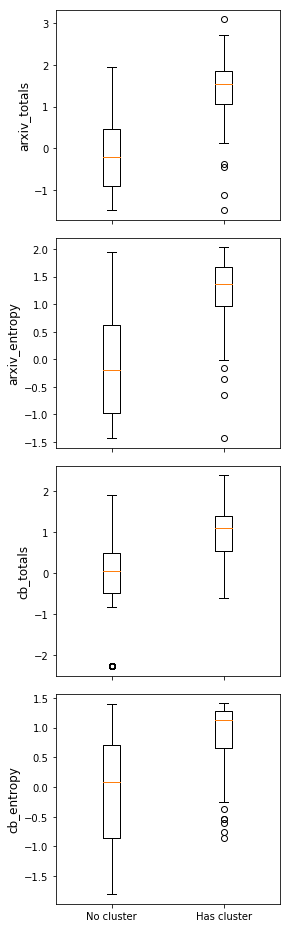

In [97]:
# Produce a bunch of boxplots comparing the independent variables for y > 1 

#Variables to plot
plot_vars = ['arxiv_totals','arxiv_entropy','cb_totals','cb_entropy']

#Lay down the plot
fig,ax = plt.subplots(nrows=(len(plot_vars)),figsize=(4,13),sharex=True)

#For each variable, draw the boxplot
for num,x in enumerate(plot_vars):
    
    ax[num].boxplot([data.loc[data['y']==0,x],data.loc[data['y']>0,x]])
    #Set title
    ax[num].set_ylabel(x,size=12)
    
    #Add labels
    ax[num].set_xticklabels(['No cluster','Has cluster'])
    
plt.tight_layout()

These boxplots are broadly consistent with the key hypotheses of our analysis: locations that acquired a concentration of DL research tended to be bigger and more diverse, and also to host stronger concentrations of tech companies based on the CrunchBase data

#### v. Modelling

Here we run a poisson regression using the data above.

In [98]:
# Remember to: 

#Cluster standard errors on country
#Do robust standard errors

import statsmodels.api as sm

data['intercept']=1

data['entropy_interaction'] = data['arxiv_entropy']*data['cb_entropy']
data['research_industry_interaction'] = data['arxiv_totals']*data['cb_totals']

x_vars = ['intercept',
          #'arxiv_totals',
          'arxiv_entropy',
          #'cb_totals',
          'cb_entropy',
          #'research_industry_interaction',
          #'entropy_interaction',
          'is_china',
          #'is_europe',
          #'cluster_t0',
          'admin_area']

data.shape

#data_2 = data.loc[data.arxiv_totals>np.median(data.arxiv_totals),:]

(716, 15)

In [99]:
#Test model with robust standard errors
test_model= sm.Poisson(data['y'],data[x_vars]).fit(
    cov_type='cluster',cov_kwds={'groups':data['country']})

Optimization terminated successfully.
         Current function value: 0.290358
         Iterations 8


In [100]:
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  716
Model:                        Poisson   Df Residuals:                      711
Method:                           MLE   Df Model:                            4
Date:                Sat, 14 Jul 2018   Pseudo R-squ.:                  0.3652
Time:                        12:29:03   Log-Likelihood:                -207.90
converged:                       True   LL-Null:                       -327.49
                                        LLR p-value:                 1.395e-50
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -3.6870      0.382     -9.651      0.000      -4.436      -2.938
arxiv_entropy     1.5132      0.272      5.553      0.000       0.979       2.047
cb_entropy        0.8394      0.492      1.706      0.088      -0.125       1.804
is_china          1.0937      0.170      6.419      0.000       0.760       1.428
admin_area        0.0026      0.002      1.232      0.218      -0.002       0.007
=================================================================================
"""

##### Save the summary as $L^AT_EX$

In [101]:
summ = test_model.summary()

beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open(fig_path+'/tables/table_poission.tex', 'w')
f.write(beginningtex)
f.write(summ.as_latex())
f.write(endtex)
f.close()

#### vi. Modelling

In [102]:
# As before, write a class that does all this.

class DlSpatialMulti():
    '''
    This class is initialised with a df with papers and the independent variables and controls dataset produced above.
    
    Methods:
    
    -.get_dl_results uses DBSCAN to extract a DL cluster taking key parameters (epsilon, lambda) and models
    cluster development with data features. 
    
    -.get_benchmark uses DBSCAN to extract DL clusters in other arXiv categories taking key parameters (epsilon, lambda) and models
    cluster development with data features. 

    -.comparison compares the results of the models.

    '''
    
    def __init__(self,papers,independent_variables):
        '''
        
        Initialise with the papers and independent variables
        
        '''
        #Store papers
        self.papers = papers
        
        #Store independent variables
        self.ind_vars = independent_variables
        
        #Dict to store models and data. We will use the keys to label the information that is stored
        self.model_store = {}
        self.data_store = {}
        
    def get_dl_results(self,thres=2012,epsilon=10,min_samples=100,
                      x_vars=['intercept',
                              #'arxiv_totals',
                              'arxiv_entropy',
                              #'cb_totals',
                              'cb_entropy',
                              #'entropy_interaction',
                              #'research_industry_interaction',
                              'is_china',
                              #'is_europe',
                              'admin_area']):
        '''
        This method extracts and models DL clusters. The inputs are a cut-off threshold for cluster emergence,
        the DBSCAN parameters and the variables to use in the prediction
        
        '''
        #Load papers
        papers = self.papers
        
        #Target container
        #The index is the number of regions
        target = pd.DataFrame(index=set(self.papers['country_reg'])-set(' '))
        
        #Get DL papers
        dl_papers = papers.loc[papers['is_dl']=='dl',:]

        #Split into two periods
        dl_papers_0 = dl_papers.loc[dl_papers['year']<thres,:]
        dl_papers_1 = dl_papers.loc[dl_papers['year']>thres,:]

        #Identify clusters in both periods
        dl_clusters_0, dl_clusters_1 = [cluster_report(paps,
                                                       dbscan(paps,
                                                              coords=['grid_lon','grid_lat'],epsilon=epsilon,
                                                              min_samples=min_samples)) for paps in [
            dl_papers_0,dl_papers_1]]
        
        
        #Get cluster frequencies in both periods
        clust_locs_0,clust_locs_1 = [
            flatten_freqs([df[4].reset_index(level=0).index]) for df in [dl_clusters_0,dl_clusters_1]]
        #Name the cluster locations in t0 (may use as contrl)
        clust_locs_0.name = 'cluster_t0'
        
        #Create the cluster frequency count
        target['y'] = pd.concat([target,clust_locs_1],axis=1,sort=True,join='outer')

        #Fill the missing values
        target.fillna(0,inplace=True)
        
        #Concatenate the cluster results with the features
        dl_data = pd.concat([target,self.ind_vars],axis=1,sort=True,join='inner').fillna(0)
        
        
        #Model using xvars. NB we are using clustered standard errors by country. 
        model= sm.Poisson(dl_data['y'],
                          dl_data[x_vars]).fit(cov_type='cluster',cov_kwds={'groups':dl_data['country']},
                                                                maxiter=5000, maxfun=5000)
        
        #Store everything
        self.data_store['dl'] = dl_data
        self.model_store['dl'] = model
        
        return(self)
        
        
    def get_benchmark_results(self,category,thres=2012,epsilon=10,min_samples=100,
                             x_vars=['intercept',
                                     #'arxiv_totals',
                                     'arxiv_entropy',
                                     #'cb_totals',
                                     'cb_entropy',
                                     'is_china',
                                     #'is_europe',
                                     #'cluster_t0',
                                     #'entropy_interaction',
                                     #'research_industry_interaction',
                                     'admin_area']):
        '''
        This method does the same as above but for a selected arXiv category.
        '''
        
        #Load papers
        papers = self.papers
        
        #Target container
        target = pd.DataFrame(index=set(self.papers['country_reg'])-set(' '))
        
        #Subset papers to find the relevant category
        subset = papers.loc[[category in arxiv_cat for arxiv_cat in papers['arxiv_categories']]]
                
        #Split into papers in t0 and papers in t1. Note that this excludes the threshold year as a 'boundary'
        subset_0 = subset.loc[subset['year']<thres]
        
        subset_1 = subset.loc[subset['year']>thres]
                
        #TODO: This is repeating the above. Refactor sometime?
        #Fit the clustering algorithm for the two subsets in the data and generate the reports
        db_report_0,db_report_1 = [cluster_report(subset,dbscan(subset,coords=['grid_lon','grid_lat'],
                                                                epsilon=epsilon,
                                                                min_samples=min_samples)) for subset in [subset_0,subset_1]]
        
        #Get cluster frequencies
        clust_locs_0,clust_locs_1 = [
            flatten_freqs([df[4].reset_index(level=0).index]) for df in [db_report_0,db_report_1]]
        clust_locs_0.name = 'cluster_t0'
        
        #Create the cluster frequency count
        target['y'] = pd.concat([target,clust_locs_1],axis=1,sort=True,join='outer')
        
        #Fill missing values
        target.fillna(0,inplace=True)
        
        #Store all the information
        #Concatenate the target, features etc
        bm_data = pd.concat([target,self.ind_vars],axis=1,sort=True,join='inner').fillna(0)
        
        
        #Model
        bm_model= sm.Poisson(bm_data['y'],
                          bm_data [x_vars]).fit(cov_type='cluster',cov_kwds={'groups':bm_data['country']},
                                                                maxiter=5000, maxfun=5000)
        #Store everything using the right key 
        self.data_store[category] = bm_data
        self.model_store[category] = bm_model
        
        return(self)
    
    def compare_results(self,ax):
        '''
        
        This method creates a barchart with confidence intervals to compare the results.
        
        '''
        
        #Load the results
        #For each key in the stored models we will extract model outputs (parameters and confidence intervals)
        parameters = []
        conf_int = []
        
        #Do this
        for x in self.model_store.keys():
            parameters.append(self.model_store[x].params)
            
            #Extract the confident intervals
            conf_ints = self.model_store[x].conf_int()
            conf_ints_low = conf_ints[0]
            conf_ints_high = conf_ints[1]
            
            conf_int.append([conf_ints_low,conf_ints_high])
        
        #Create dataframes and give them columns
        model_results_df = pd.concat(parameters,axis=1)
        conf_int_low_df = pd.concat([x[0] for x in conf_int],axis=1)
        conf_int_high_df = pd.concat([x[1] for x in conf_int],axis=1)
        
        #Variable names
        model_results_df.columns= self.model_store.keys()
        conf_int_low_df.columns= self.model_store.keys()
        conf_int_high_df.columns= self.model_store.keys()
        
        #And to plot
        my_vars = [
            #'arxiv_totals',
            'arxiv_entropy',
            #'cb_totals',
            'cb_entropy',
            #'research_industry_interaction',
            #'entropy_interaction',
            'is_china',
            #'is_europe'
        ]
        
        #DFs to plot
        plot_df = model_results_df.loc[my_vars]
        low = conf_int_low_df.loc[my_vars]
        high = conf_int_high_df.loc[my_vars]

        # Do the barplot
        #Number of bars in the x axis
        x_n = np.arange(len(plot_df))

        for num,col in enumerate(plot_df.columns):
            ax.bar(x=x_n+0.15*num,
                   height=plot_df[col],
                   width=0.15,
                   #yerr=[high[col],low[col]],
                   yerr = np.array(low[col],high[col]),
                   align='center', 
                   ecolor='black', capsize=3,alpha=0.5
                  )
            #print(plot_df[col])
            #print(low[col])
            #print(high[col])

        ax.set_xticks(x_n+0.25)
        ax.set_xticklabels(my_vars,rotation=45,ha='right',size=12)

        ax.legend(list(plot_df.columns),loc='upper right',title='Category',fontsize=12,ncol=len(model_results_df))
        ax.set_title('Coefficients for key variables in Poisson Regression',size=16)
        
        self.params = plot_df
        self.conf_int = [low,high]
        

##### **Test**

We run the class above for a set of categories, extract key information and produce visualisations 

In [103]:
#These are the 'shared' independent variables
data = pd.concat([pred_norm,control.drop('cluster_t0',axis=1)],axis=1,sort=False,join='inner').fillna(0)
data['intercept']=1
data['entropy_interaction'] = data['arxiv_entropy']*data['cb_entropy']
data['research_industry_interaction'] = data['arxiv_totals']*data['cb_totals']

In [104]:
['cs.NI', 'cs.DM', 'cs.CC', 'cs.DS', 'cs.LO', 'cs.IT']

['cs.NI', 'cs.DM', 'cs.CC', 'cs.DS', 'cs.LO', 'cs.IT']

In [105]:
#xs are the indep variables
xs = data

#Initialie
test = DlSpatialMulti(mv_data,xs)
test.get_dl_results(min_samples=100,epsilon=10)

for cat in ['cs.NI','cs.IT','cs.DS','cs.CR']:
    print(cat)
    test.get_benchmark_results(cat,min_samples=50,epsilon=10)

Optimization terminated successfully.
         Current function value: 0.290358
         Iterations 8
cs.NI
Optimization terminated successfully.
         Current function value: 0.178117
         Iterations 7
cs.IT
Optimization terminated successfully.
         Current function value: 0.371160
         Iterations 7
cs.DS
Optimization terminated successfully.
         Current function value: 0.208306
         Iterations 8
cs.CR
Optimization terminated successfully.
         Current function value: 0.134642
         Iterations 7


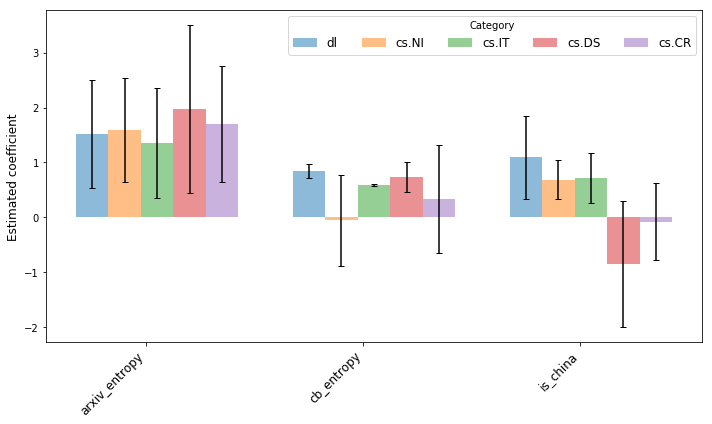

In [106]:
fig,ax = plt.subplots(figsize=(10,6))
test.compare_results(ax=ax)

ax.set_title('')
ax.set_ylabel('Estimated coefficient',fontsize=12)
#ax.set_ylab

plt.tight_layout()

plt.savefig(fig_path+'/paper_figures/figure_7_poisson_comparison.pdf',bbox_to_inches='tight')


Optimization terminated successfully.
         Current function value: 0.415617
         Iterations 8
cs.NE
Optimization terminated successfully.
         Current function value: 0.100185
         Iterations 8
cs.AI
Optimization terminated successfully.
         Current function value: 0.175965
         Iterations 8
cs.CV
Optimization terminated successfully.
         Current function value: 0.279045
         Iterations 8
cs.CL
Optimization terminated successfully.
         Current function value: 0.163320
         Iterations 8
stat.ML
Optimization terminated successfully.
         Current function value: 0.234098
         Iterations 8


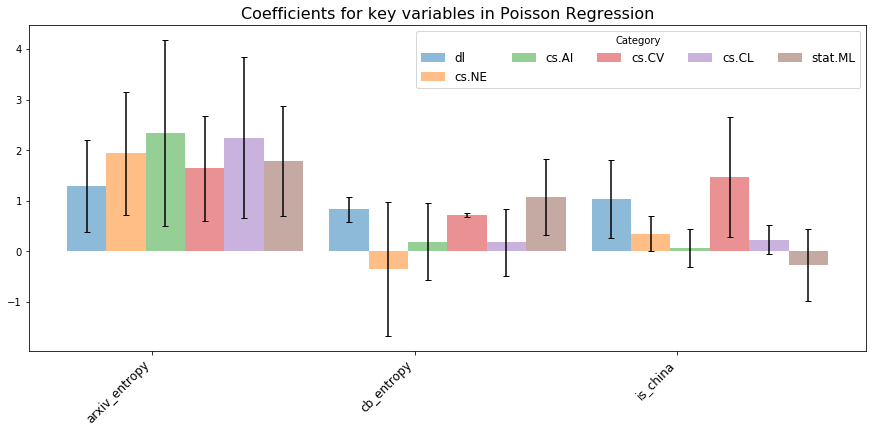

In [107]:
#xs are the indep variables
xs = data

#Initialie
test_2 = DlSpatialMulti(mv_data,xs)
test_2.get_dl_results(min_samples=50,epsilon=10)

for cat in ['cs.NE','cs.AI','cs.CV','cs.CL','stat.ML']:
    print(cat)
    test_2.get_benchmark_results(cat,min_samples=50,epsilon=10)
    
fig,ax = plt.subplots(figsize=(15,6))
test_2.compare_results(ax=ax)

In [108]:
comb = pd.concat([cb_totals,arxiv_totals],axis=1).fillna(0)

comb.sort_values('arxiv_totals',ascending=False,inplace=True)

comb = comb.apply(lambda x: x/x.sum(),axis=0).iloc[:100,:]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [109]:
comb.corr()

,cb_totals,arxiv_totals
cb_totals,1.000000,0.875441
arxiv_totals,0.875441,1.000000


### Crude analysis of the situation in China

In [110]:
country_collabs = papers_clust.groupby('arxiv_id')['country'].apply(lambda x: list(x)).reset_index(drop=False)

In [111]:
country_collabs['china_us'] = [('China' in x) & ('United States of America' in x) for x in country_collabs['country']]

country_collabs['is_dl'] = [x in papers_expansive for x in country_collabs['arxiv_id']]

country_collabs['year'] = [papers_meta.loc[x,'year'] for x in country_collabs['arxiv_id']]

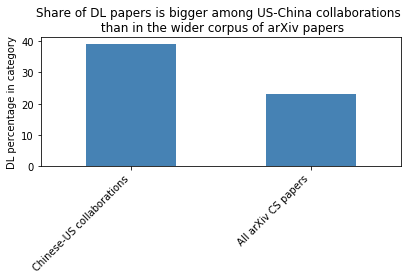

In [112]:
dl_ct = pd.crosstab(country_collabs['china_us'],country_collabs['is_dl'],margins=1)

china_us_shares = dl_ct[True]/dl_ct['All']

fig,ax = plt.subplots()

(100*china_us_shares[[True,'All']]).plot.bar(color='steelblue',title='Share of DL papers is bigger among US-China collaborations \n than in the wider corpus of arXiv papers',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('DL percentage in category')
ax.set_xticklabels(['Chinese-US collaborations','All arXiv CS papers'],rotation=45,ha='right')

plt.tight_layout()

plt.savefig('/Users/jmateosgarcia/Desktop/china_collabs.png')


/usr/local/lib/python3.7/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


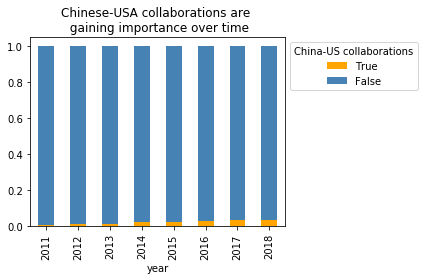

In [113]:
dl_papers_recent = country_collabs.loc[(country_collabs['year']>2010) & (country_collabs['is_dl']==True),:]

fig,ax = plt.subplots()
pd.crosstab(dl_papers_recent['year'],dl_papers_recent['china_us'],normalize=0).iloc[:,[1,0]].plot.bar(
    stacked=True,ax=ax,
    colors=['orange','steelblue'],title='Chinese-USA collaborations are \n gaining importance over time')

ax.legend(bbox_to_anchor=(1,1),title='China-US collaborations')
plt.tight_layout()

plt.savefig('/Users/jmateosgarcia/Desktop/china_collabs_time.png')


In [114]:
len(papers_meta)

131189

## Alternative models

In the simpler, alternative model, we will estimate DL LQs for each region and model that with the other predictors.


In [115]:
n_iters = 5
import scipy.stats as ss

def calc_ECI_plus(X, n_iters):
    ECI_mat = np.zeros((X.shape[0], n_iters))
    x = X.values.sum(axis=1)
    x = x/ss.gmean(x)
    ECI_mat[:, 0] = x

    for n in range(1, n_iters):
        x = (X.values/(X.values/ECI_mat[:, n-1][:, np.newaxis]).sum(0)).sum(1)
        x = x/ss.gmean(x)
        ECI_mat[:, n] = x

    ECI = np.log(ECI_mat[:, -1]) - np.log((X/X.sum(0)).sum(1))
    
    return pd.DataFrame(ECI_mat, index=ECI.index), ECI

arxiv_eci = calc_ECI_plus(create_lq_df(arxiv_cat_totals),n_iters=5)[1]
cb_eci = calc_ECI_plus(create_lq_df(cb_cat_totals),n_iters=5)[1]

ecis= pd.concat([arxiv_eci,cb_eci],axis=1)
ecis.columns=['arxiv_eci','cb_eci']

ecis['eci_interaction'] = ecis['arxiv_eci']*ecis['cb_eci']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [137]:
dl_0 = create_lq_df(pd.crosstab(papers_clust.loc[papers_clust.year<2012,'country_reg'],
                               papers_clust.loc[papers_clust.year<2012,'is_dl']))

dl_1 = create_lq_df(pd.crosstab(papers_clust.loc[papers_clust.year>2012,'country_reg'],
                               papers_clust.loc[papers_clust.year>2012,'is_dl']))

dl_periods = pd.concat([dl_0['dl'],dl_1['dl']],axis=1,join='inner')
dl_periods.columns=['dl_0','dl_1']

data_2 = pd.concat([dl_periods,data,ecis],axis=1,join='inner')

data_2 = data_2.loc[data_2.arxiv_totals>np.percentile(data_2.arxiv_totals,25),:]

data_2.corr()

,dl_0,dl_1,arxiv_totals,arxiv_total_discs,arxiv_entropy,cb_totals,cb_total_sectors,cb_entropy,is_china,is_europe,admin_area,intercept,entropy_interaction,research_industry_interaction,arxiv_eci,cb_eci,eci_interaction
dl_0,1.000000,0.166699,0.074497,0.064328,0.033636,0.014831,0.033772,0.014003,0.084186,0.006429,0.050857,NaN,0.040131,0.063728,0.014197,0.024470,0.018945
dl_1,0.166699,1.000000,0.156471,0.169527,0.171176,0.150560,0.149849,0.092911,0.334584,-0.176824,0.143236,NaN,0.050505,0.129599,0.100385,0.038473,0.083787
arxiv_totals,0.074497,0.156471,1.000000,0.905719,0.700821,0.564698,0.654870,0.507879,0.010011,-0.000723,0.138524,NaN,0.610660,0.742365,0.596209,0.341815,0.620924
arxiv_total_discs,0.064328,0.169527,0.905719,1.000000,0.845284,0.571286,0.687570,0.498814,0.009222,-0.043489,0.156883,NaN,0.673774,0.777830,0.612948,0.333282,0.636833
arxiv_entropy,0.033636,0.171176,0.700821,0.845284,1.000000,0.483241,0.512569,0.447902,0.038455,-0.002538,0.110016,NaN,0.524859,0.534283,0.565219,0.303075,0.546717
cb_totals,0.014831,0.150560,0.564698,0.571286,0.483241,1.000000,0.787276,0.939527,-0.014363,-0.013504,0.202579,NaN,0.498701,0.598517,0.420415,0.689323,0.656786
cb_total_sectors,0.033772,0.149849,0.654870,0.687570,0.512569,0.787276,1.000000,0.702347,-0.064682,-0.186841,0.279667,NaN,0.677447,0.840612,0.457917,0.553829,0.665050
cb_entropy,0.014003,0.092911,0.507879,0.498814,0.447902,0.939527,0.702347,1.000000,-0.046951,0.059338,0.151417,NaN,0.455888,0.499278,0.401001,0.758016,0.601890
is_china,0.084186,0.334584,0.010011,0.009222,0.038455,-0.014363,-0.064682,-0.046951,1.000000,-0.190730,0.081639,NaN,-0.018030,-0.023518,-0.020454,-0.062630,-0.047434
is_europe,0.006429,-0.176824,-0.000723,-0.043489,-0.002538,-0.013504,-0.186841,0.059338,-0.190730,1.000000,-0.293307,NaN,-0.087122,-0.154931,0.035002,-0.014106,-0.040748


In [139]:
data_2.fillna(0,inplace=True)

data_2.shape

# Remember to: 

#Cluster standard errors on country
#Do robust standard errors

import statsmodels.api as sm


x_vars = ['intercept',
          #'arxiv_totals',
          'arxiv_entropy',
          #'cb_totals',
          'cb_entropy',
          #'research_industry_interaction',
          #'arxiv_eci',
          #'cb_eci',
          'entropy_interaction',
          'is_china',
          'is_europe',
          'dl_0',
          'admin_area']

#data_2 = data_2.loc[data_2.arxiv_totals>np.median(data_2.arxiv_totals),:]

#Test model with robust standard errors
test_model= sm.OLS(data_2['dl_1'],data_2[x_vars]).fit(
    cov_type='cluster',cov_kwds={'groups':data_2['country']})

test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   dl_1   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     488.6
Date:                Sat, 14 Jul 2018   Prob (F-statistic):           2.13e-57
Time:                        12:41:40   Log-Likelihood:                -478.84
No. Observations:                 483   AIC:                             973.7
Df Residuals:                     475   BIC:                             1007.
Df Model:                           7                                         
Covariance Type:              cluster                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept               0.6553      0.083      7.856      0.000       0.492       0.819
arxiv_entropy           0.1518      0.061      2.500      0.012       0.033       0.271
cb_entropy              0.0601      0.067      0.897      0.370      -0.071       0.191
entropy_interaction    -0.0796      0.046     -1.741      0.082      -0.169       0.010
is_china                1.1068      0.064     17.309      0.000       0.981       1.232
is_europe              -0.1639      0.081     -2.015      0.044      -0.323      -0.005
dl_0                    0.0349      0.011      3.178      0.001       0.013       0.056
admin_area              0.0022      0.001      2.468      0.014       0.000       0.004
==============================================================================
Omnibus:                      152.839   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              387.026
Skew:                           1.591   Prob(JB):                     9.09e-85
Kurtosis:                       6.018   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""